# Classifiez automatiquement des biens de consommation

Vous êtes Data Scientist au sein de l’entreprise "**Place de marché**”, qui souhaite lancer une marketplace e-commerce.


Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible et dans l'optique d'un passage à l'échelle, **il devient nécessaire d'automatiser cette tâche**.

**Linda**, lead data scientist, vous demande donc d'étudier la faisabilité d'un **moteur de classification** des articles en différentes catégories, avec un niveau de précision suffisant.

## Les données
Linda vous a fourni un premier jeu de données d’articles avec le lien pour télécharger la photo et une description associée.

## Votre mission
Votre mission est de **réaliser une première étude de faisabilité d'un moteur de classification** d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

Vous **analyserez le jeu de données** en **réalisant un prétraitement** des images et des descriptions des produits, une **réduction de dimension**, puis un **clustering**. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

La représentation graphique vous aidera à convaincre Linda que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

Attention, Linda n’a pas besoin d’un moteur de classification à ce stade, mais bien d’une étude de faisabilité !

__Contraintes__
Linda vous a communiqué la contrainte suivante : afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF.

Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration.

## Livrables attendus
Un **notebook** (ou des fichiers .py) contenant les fonctions permettant le prétraitement des données textes et images ainsi que les résultats du clustering (en y incluant des représentations graphiques au besoin).
Un support de **présentation** qui présente la démarche et les résultats du clustering.

# Analyse exploratoire des données textuelles

**[I Préparation du jeu de données](#I-Préparation-du-jeu-de-données)**
* [I.1 Chargement du jeu de données](#I.1-Chargement-du-jeu-de-données)
* [I.2 Création des catégories](#I.2-Création-des-catégories)

**[II Nettoyage et normalisation du corpus](#II-Nettoyage-et-normalisation-du-corpus)**
* [II.1 Vérification du langage utilisé](#II.1-Vérification-du-langage-utilisé)
* [II.2 Fonctions de prétraitement](#II.2-Fonctions-de-prétraitement)
* [II.3 Création du corpus](#II.3-Création-du-corpus)
* [II.4 Analyse exploratoire: mots les plus fréquents](#II.4-Analyse-exploratoire:-mots-les-plus-fréquents)
    * [II.4.1 Les 50 mots les plus fréquents](#II.4.1-Les-50-mots-les-plus-fréquents)
    * [II.4.2 Mots les plus fréquents par catégorie de produits](#II.4.2-Mots-les-plus-fréquents-par-catégorie-de-produits)

**[III Latent Semantic Analysis et évaluation des catégories originales](#III-Latent-Semantic-Analysis-et-évaluation-des-catégories-originales)**
* [III.1 Processing pipeline](#III.1-Processing-pipeline)
    * [III.1.1 Représentation "bag-of-words" - _Document-term matrix_](#III.1.1-Représentation-"bag-of-words"---Document-term-matrix)
    * [III.1.2 Latent Semantic Analysis](#III.1.2-Latent-Semantic-Analysis)
* [III.2 Evaluation des paramètres optimaux par _gridsearch_](#III.2-Evaluation-des-paramètres-optimaux-par-gridsearch)
* [III.3 Résultats](#III.3-Résultats)
    * [III.3.1 Encodage des "vraies" catégories](#III.3.1-Encodage-"vraies"-catégories)
    * [III.3.2 Affichage des résultats](#III.3.2-Affichage-des-résultats)

**[IV Apprentissage non-supervisé de catégories](#IV-Apprentissage-non-supervisé-de-catégories)**

In [431]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import itertools
import time
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np 
from numpy.random import default_rng
import re
import p6
import textprocessing
import pickle

from langdetect import DetectorFactory
DetectorFactory.seed = 0
from langdetect import detect
from langdetect import detect_langs

from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm

import sys

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
from sklearn import manifold
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import cluster
from sklearn.model_selection import ParameterGrid

import yellowbrick as yb
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
yb.reset_orig()

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import hdbscan

# Scripts

In [825]:
def prepare_text(sample, **kwargs):
    # création d'un motif regex à partir de quelques phrases récurrentes et non-informatives. 
    sentences_to_remove = ['rs.', 
                           'flipkart.com',
                           'free shipping',
                           'cash on delivery', 
                           'only genuine products', 
                           '30 day replacement guarantee',
                           '\n',
                           '\r',
                           '\t',
                           r'\bcm\b',
                           r'\bbuy\b',
                           r'\bl\b'
                          ]

    sent_rm = kwargs.pop('sentences_to_remove', sentences_to_remove)
    pattern = "|".join(sentences_to_remove)
    cleaned_text = re.sub(pattern, ' ', sample)
    pattern_2 = re.compile(r"\s{2,}")
    cleaned_text = re.sub(pattern_2, ' ', cleaned_text)
    return cleaned_text

def get_lemma(tokens, lemmatizer, stop_words):
    lemmatized = []
    for item in tokens:
        if item not in stop_words:
            lemmatized.append(lemmatizer.lemmatize(item))
    return lemmatized


def tokenize(sample, **kwargs):
    tokenizer = kwargs.pop('tokenizer', None)
    if tokenizer:
        tokens = tokenizer.tokenize(sample)
        lemma = kwargs.pop('lemmatizer', None)
        stop_w = kwargs.pop('stop_words', None)
        if lemma:
            if stop_w:
                lemmas = get_lemma(tokens, lemmatizer, stop_w)
            else:
                lemmas = get_lemma(tokens, lemmatizer)
        else:
            lemmas = tokens
        
        return lemmas
    else:
        print("Missing tokenizer") 
        

def process_text(sample):
    # motif regex pour la tokenization. Ce motif filtre directement les caractères spéciaux 
    # comme \n, \t \r etc., ainsi que les chiffres.
    pattern = re.compile(r'[a-zA-Z]+')
    cleaned = prepare_text(sample)
    tokens = tokenize(cleaned, tokenizer=tokenizer,lemmatizer=lemmatizer,stop_words=SW)

    return ' '.join(tokens)


def word_freq(corpus):
    
    # construction du dictionnaire des fréquences
    freq_dist = Counter()
    for text in corpus:
        for token in text.split(' '):
            freq_dist[token] += 1
    
    return freq_dist
    
    
# Fonction de filtrage des mots (les plus rares et les plus fréquents)
def filter_tokens(corpus, freq_dist, min_tf, max_tf):
    
        # On retire les tokens tels que word_freq[token] < min_tf ou > max_tf
        new_corpus = [' '.join([token for token in text.split(' ') 
                                if (freq_dist[token] > min_tf) and (freq_dist[token] < max_tf)
                               ])
                      for text in corpus]
        
        return new_corpus
            

def make_docterm_matrix(corpus, idf_transform=True, **kwargs):
    
    freq_dist = word_freq(corpus)
    
    max_tf = kwargs.pop('max_tf', None)
    if max_tf is None:
        max_tf = max(freq_dist.values())
    
    min_tf = kwargs.pop('min_tf', 1)
    corpus = filter_tokens(corpus, freq_dist, min_tf, max_tf)
    
    max_df = kwargs.pop('max_df', 1.0)
    min_df = kwargs.pop('min_df', 1)
    n_gram = kwargs.pop('ngram_range', (1, 1))
    
    tfidfargs = {'max_df':max_df, 'min_df':min_df, 'ngram_range':n_gram}
    
    tfidf = TfidfVectorizer(**tfidfargs)
    values = tfidf.fit_transform(corpus)
    
    return tfidf, values.todense()



def lda_scorer(corpus, true_labels=None, ari=False, **kwargs):
    
    # création de la matrice 'bag_of_words'
    _, docterm = make_docterm_matrix(corpus, **kwargs)
    
    # Latent Dirichlet Allocation
    n_topics = kwargs.pop('n_topics', 7)
    doc_topic_prior = kwargs.pop('doc_topic_prior', None)
    topic_word_prior = kwargs.pop("topic_word_prior", None)
    
    lda = decomposition.LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='online',
        doc_topic_prior=doc_topic_prior,
        topic_word_prior=topic_word_prior
    )
    
    # Fit
    lda.fit(docterm)
    
    if ari:
        # Evaluation
        # Assignation des catégories à chaque produit: la catégorie retenue est celle pour laquelle la proba est maximale
        X_topics = lda.transform(docterm)
        topics = np.argmax(X_topics, axis=1)
    
        return [metrics.adjusted_rand_score(true_labels, topics)]
    
    else:
        return [lda.score(docterm)]

    
def custom_gridsearch(tokenized_corpus, grid, method='lda', ari=True, labels=None, verbose=1):
    
    results = []
    i = 0
    tinit = time.time()
    param_grid = ParameterGrid(grid)

    for g in param_grid:
        
        t0 = time.time()
        i += 1
        
        if verbose > 0:
            print("Evaluation du modèle...{}/{}".format(i, len(param_grid)))
            for k, v in g.items():
                print("{} = {}".format(k, v))
            print()
        
        if method=='lda':
            score = lda_scorer(tokenized_corpus,
                                     labels,
                                     ari=ari,
                                     **kwargs)
            score_name = ["score"]
            
        elif method=='tsne':
            score = lsa_tsne_scorer(tokenized_corpus, labels, **kwargs)
            score_name = ["silhouette_score", "davies_bouldin_score"]
        
        results.append([*kwargs.values(),
                        *score])
         
        if verbose > 1:
            
            step_duration = time.time() - t0
            global_duration = time.time() - tinit
            avg_per_step = (global_duration + step_duration)/(i + 1)
        
            nb_h = avg_per_step*(len(param_grid) - i) // 3600
            nb_min = (avg_per_step*(len(param_grid) - i) % 3600) // 60
            nb_sec = int((avg_per_step*(len(param_grid) - i) % 3600) % 60)
            print("temps restant estimé: {} h {} min {} s".format(nb_h, nb_min, nb_sec))
            print('-'*40)
            print()
    
    
    cols = list(g.keys())
    for s in score_name:
        cols.append(s)

    results = pd.DataFrame(data=results, columns=cols)

    if method=='lda':
        best_score = results["score"].max()
        index = results[results["score"]==best_score].index[0]
        best_params = results[results["score"]==best_score].transpose().rename(columns={index:"Paramètres"})
        print("Meilleur score: {:.3f}".format(best_score))
        print("Hyperparamètres utilisés pour obtenir le meilleur score: ")
        print(best_params)
        
    return results


def create_lsa_tsne_pipeline(**kwargs):
            
    n_components = kwargs.pop('n_components', 2)
    perplexity = kwargs.pop('perplexity', 30)
    n_iterations = kwargs.pop('iterations', 1000)
    
    kwargs2 = {'n_components':n_components}
    kwargs3 = {'perplexity':perplexity,'n_iter':n_iterations}
    
    lsa_tsne = pipeline.make_pipeline(decomposition.TruncatedSVD(**kwargs2),
                                  preprocessing.Normalizer(copy=False),
                                  manifold.TSNE(**kwargs3))
    
    return lsa_tsne


def lsa_tsne_scorer(corpus, labels, **kwargs):
    

    ngram_range = kwargs.pop('ngram_range', (1,1))
    kwargs1 = {'ngram_range':ngram_range}
    
    n_components = kwargs.pop('n_components', 2)
    perplexity = kwargs.pop('perplexity', 30)
    n_iterations = kwargs.pop('iterations', 1000)
    
    kwargs2 = {'n_components':n_components, 
               'perplexity':perplexity,
               'n_iter':n_iterations}
    
    _, docterm = make_docterm_matrix(corpus, idf_transform=True, **kwargs1)
    lsa_tsne = create_lsa_tsne_pipeline(**kwargs2)
    

    print("Création de la représentation 2D par t-SNE... ")
    print("perplexity = {}, n_iterations = {}, ngram_range = {}".format(kwargs2["perplexity"], 
                                                                        kwargs2["n_iter"],
                                                                        kwargs1["ngram_range"]))
    array_tsne = lsa_tsne.fit_transform(docterm)

    df_tsne = pd.DataFrame(data=array_tsne, columns=["t-SNE 0", "t-SNE 1"])
    silh_score = metrics.silhouette_score(df_tsne, labels)
    db_score = metrics.davies_bouldin_score(df_tsne, labels)
    
    score = [silh_score, db_score]
    return score
    

def compute_distorsion(X, topics):
    
    distorsions = []
    
    for t in np.unique(topics):
        cluster_indices = np.where(topics==t)
        centroid = X[cluster_indices].sum(axis=0) / len(cluster_indices[0])
        distorsions.append((np.square(X[cluster_indices] - centroid)).sum(axis=1))
    distorsion = np.sum(list(itertools.chain.from_iterable(distorsions)))
    
    return distorsion


def plot_silhouette_analysis(X, data, label_col):
        
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, data[label_col])
    
    # Compute the silhouette score for all values
    silhouette_avg = metrics.silhouette_score(X, data[label_col])
    
    y_lower = 10
    for i in range(data[label_col].nunique()):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[data[label_col] == i]
    
        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
        color = mpl.cm.nipy_spectral(float(i) / data[label_col].nunique())
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
    
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = mpl.cm.nipy_spectral(data[label_col].astype(float) / data[label_col].nunique())
    ax2.scatter(
        X[:, 0], X[:, 1], 
        marker=".", 
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor="k"
    )
    
    
    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    centroids = []
    labels = data[label_col].unique()
    labels.sort()
    for l in labels:
        cluster_indices = np.where(data[label_col]==l)
        centroids.append(X[cluster_indices].sum(axis=0) / len(cluster_indices[0]))
    
    centroids = np.asarray(centroids)
    
    # Draw white circles at cluster centers
    ax2.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    
    for i, c in enumerate(centroids):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    plt.tight_layout()
    plt.show()
    
    
def plot_gs_results(results, score, axis_scale="log", plot_param=["alpha"], savefig=False, figname='untitled'):
    """Plots GridSearchCV results.
    
    Draw a plot (one plot per hyperparameter) of mean_train and mean_test scores/errors 
    for each hyperparameter being optimised.
    
    Parameters
    ----------
    cv_results : pandas.DataFrame
        GridSearchCV cross-validation results
    
    score : str or tuple
        Metric(s) used to evaluate the predictions
        
    axis_scale : str, default="log"
        Type of scale to use to draw the plot. Basically 'linear' or 'log' depending on the hyperparameter
    
    plot_param : list, default=["alpha"]
        Hyperparameter against which to plot cross-validated results
        
    savefig : bool, default=False
        Whether or not to save the plot to a .png file.
        
    figname : str, default='untitled'
        Name to give the file if savefig is True.
        
        
    """
    fig = plt.figure(figsize=(5*(len(plot_param)//2 + 1), 4*2))
    
    # Affiche les scores obtenus sur les jeux d'entrainement et de test
    for i, pp in enumerate(plot_param):
        d = results.set_index("{}".format(pp))
        cols = []
        for s in score: 
                cols.append("{}".format(s))
                
        if None in d.index:
            d.rename(index={None: 'None'})
        
        ax = fig.add_subplot(2, len(plot_param)//2 + 1, i+1)
        sns.lineplot(data=d[cols], ci='sd', ax=ax)
        ax.set_xscale(axis_scale)
        ax.set_xlabel(pp, size=12)
        ax.legend(loc='best', frameon=False, fontsize='small')
        
        # We change the fontsize of minor ticks label 
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        
    if savefig:
        plt.savefig(f'./{figname}', dpi=300)
        
    plt.tight_layout()


def visualize_tsne(data, X_tsne, label_col, title="K-Means clusterization"):
    
    X_tsne = pd.DataFrame(data=X_tsne, columns=["t-SNE 0", "t-SNE 1"])
    df = pd.concat([X_tsne, data[[label_col, "product_category_0"]]], axis=1)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(12, 5))

    sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue=label_col, palette='tab20', legend=False, ax=ax1)
    #ax1.legend(np.arange(len(np.unique(df.hdbs_label)))-1)
    ax1.set_title(title)

    sns.scatterplot(data=df, x="t-SNE 0", y="t-SNE 1", hue="product_category_0", palette='tab10', ax=ax2)
    ax2.set_title("Original segmentation (level 0)")
    # Put the legend out of the figure
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()


def eval_clustering(true_labels, cluster_labels, text="LDA"):
    # Encodage numérique des vraies catégories
    print("ARI entre les étiquettes obtenues par {} et les vraies étiquettes: {:.2f}"
          .format(text, metrics.adjusted_rand_score(true_labels, cluster_labels)))


def conf_mat_transform(y_true, y_pred, corresp=None):
    
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
        
    if not corresp:
        corresp = np.argmax(conf_mat, axis=0)
    #corresp = [3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']


def hdbs_clustering(X, data, model):

    model.fit(X)
    hdbs_labels = model.labels_
    print("Nombre de clusters trouvés (le bruit compte pour un cluster): {}"
          .format(len(np.unique(hdbs_labels))))
    data["hdbs_label"] = hdbs_labels
    
    return data

Le but de ce travail est de réaliser une segmentation de produits issus du site Flipkart.com et listés dans le jeu de données flipkart_com-ecommerce_sample_1050.csv.  
Pour y parvenir on cherchera à identifier un nombre (restreint) de catégories dans lesquelles regrouper ces produits en utilisant les descriptions qui leur sont associées, et en leur appliquant un traitement visant à en extraire les informations principales. 
La pertinence de la segmentation sera évaluée en comparant, grâce à diverses métriques appropriées, les segments déterminés de façon non-supervisée avec les catégories de produits établies par la plateforme Flipkart.com.

# I Préparation du jeu de données

## I.1 Chargement du jeu de données

Commençons par charger le jeu de données.

In [111]:
try:
    data = p6.load_data()
except:
    rootpath = "./data/Flipkart/"
    data = pd.read_csv(rootpath+"flipkart_com-ecommerce_sample_1050.csv")
    data.head()

## I.2 Création des catégories

Commençons par afficher les 5 premières lignes du dataset. Quelles sont les colonnes pertinentes dans notre contexte?

In [112]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


Comme indiqué au-dessus, les données qui vont nous intéresser ici sont:
- les descriptions des produits
- les noms des produits
- les catégories auxquelles ils appartiennent

In [109]:
data = data[["product_name", "product_category_tree", "description"]]

La colonne product_category_tree semble intéressante, mais son formatage empêche son utilisation dans l'immédiat. On va donc réaliser un traitement de cette colonne de façon à séparer les différents nveaux de "l'arbre" de catégories

Nombre de catégories différentes par niveau:
--------------------------------------------------
0      7
1     62
2    241
3    349
4    297
5    117
6     57
dtype: int64


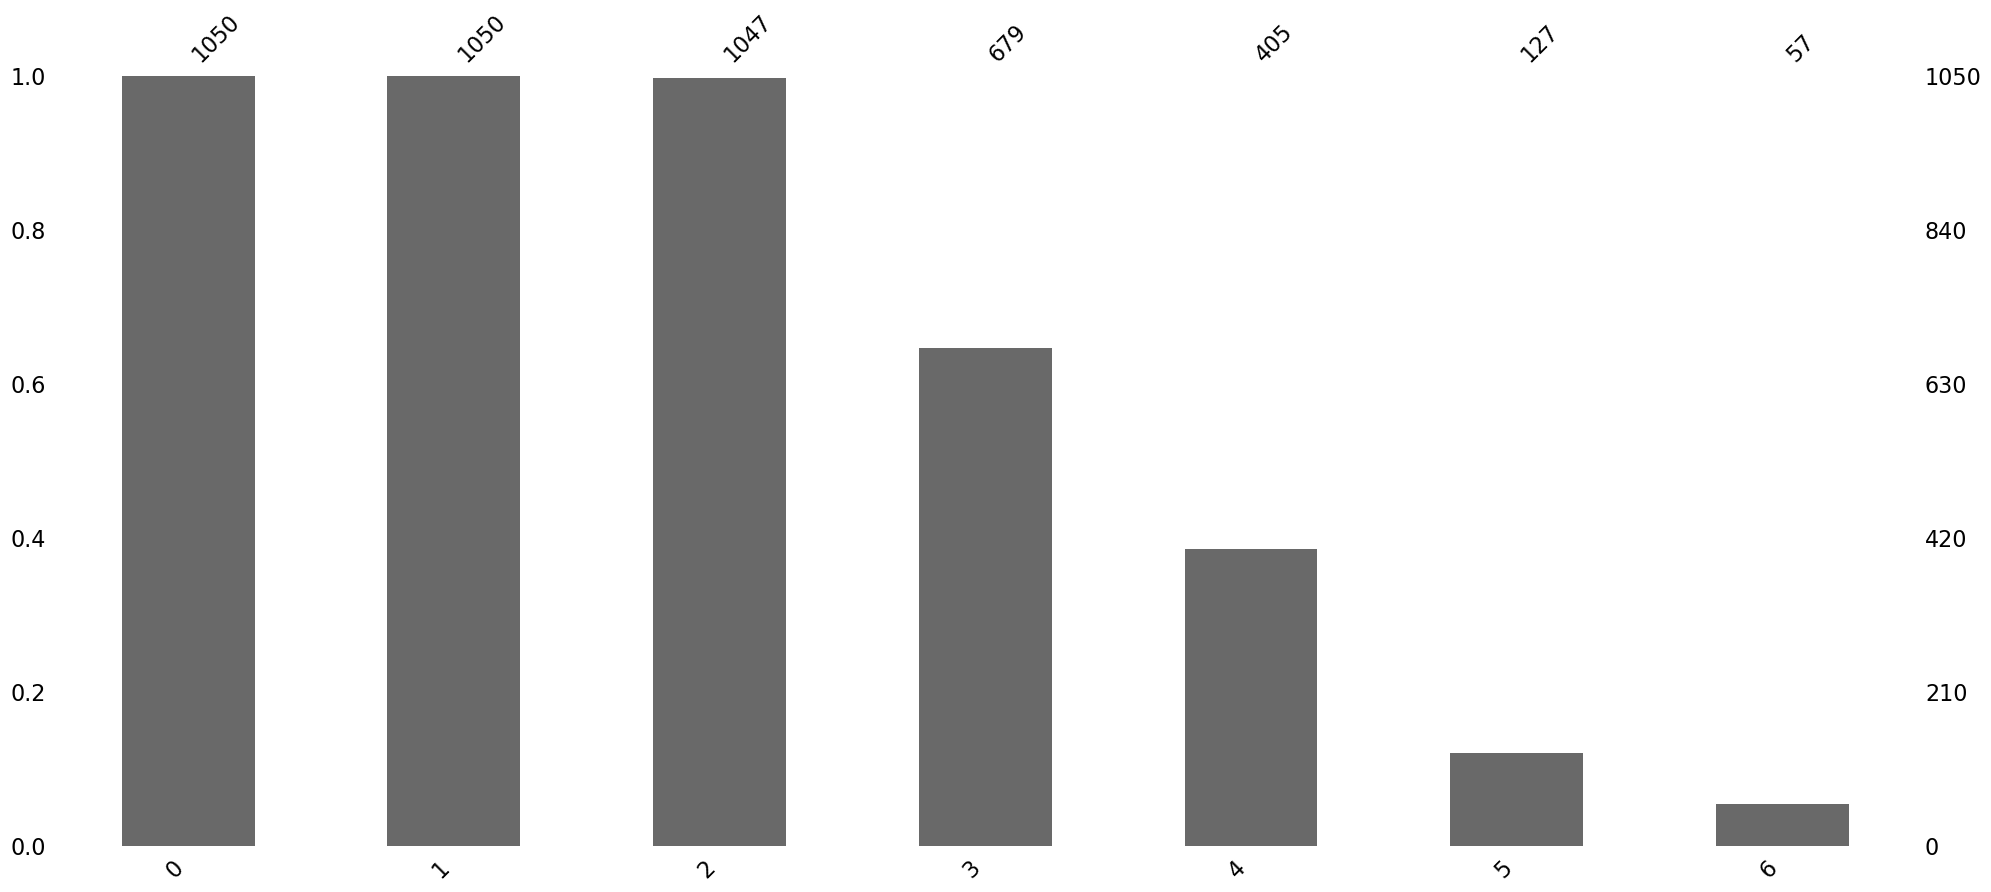

In [113]:
categories = p6.category_trees(data)
msno.bar(categories)
print("Nombre de catégories différentes par niveau:")
print("-"*50)
print(categories.nunique())

On a donc au plus 6 niveaux de catégorisation. Seules les deux premières concernent la totalité des produits. On peut maintenant donner un aperçu des différentes catégories utilisées dans chaque niveau

In [9]:
categories

,0,1,2,3,4,5,6
0,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,None,None,None
1,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",None,None
2,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,None,None
3,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,None,None
4,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,None,None
...,...,...,...,...,...,...,...
1045,Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers,None,None,None
1046,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None
1047,Baby Care,Baby & Kids Gifts,Stickers,Uberlyfe Stickers,None,None,None
1048,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None


Comme seuls les deux premiers niveaux sont complètement renseignés, et que le nombre de catégories différentes devient très important au-delà, on se contentera de ne retenir que les deux premiers niveaux, que l'on renomme product_category_0 et product_catgory_1

In [114]:
data["product_category_0"] = p6.extract_categories_from_tree(data)
data["product_category_1"] = p6.extract_categories_from_tree(data, level=1)
data = data[["product_name", "description", "product_category_0", "product_category_1"]]
data.head()

,product_name,description,product_category_0,product_category_1
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Curtains & Accessories
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Baby Bath & Skin
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Baby Bath & Skin
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,Bed Linen
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Bed Linen


Le jeu de données est prêt à être utilisé. On peut maintenant inspecter un peu plus en détail ces différentes catégories. Sont-elles équilibrées? Les catégories de niveau 1 appartiennent-elles exclusivement à une catégorie de niveau 0, ou sont-elles partagées entre plusieurs catégories de niveau 0?

**Combien de produits par catégorie? Les catégories sont-elles équilibrées?**

In [115]:
data.groupby('product_category_0').size()

product_category_0
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
dtype: int64

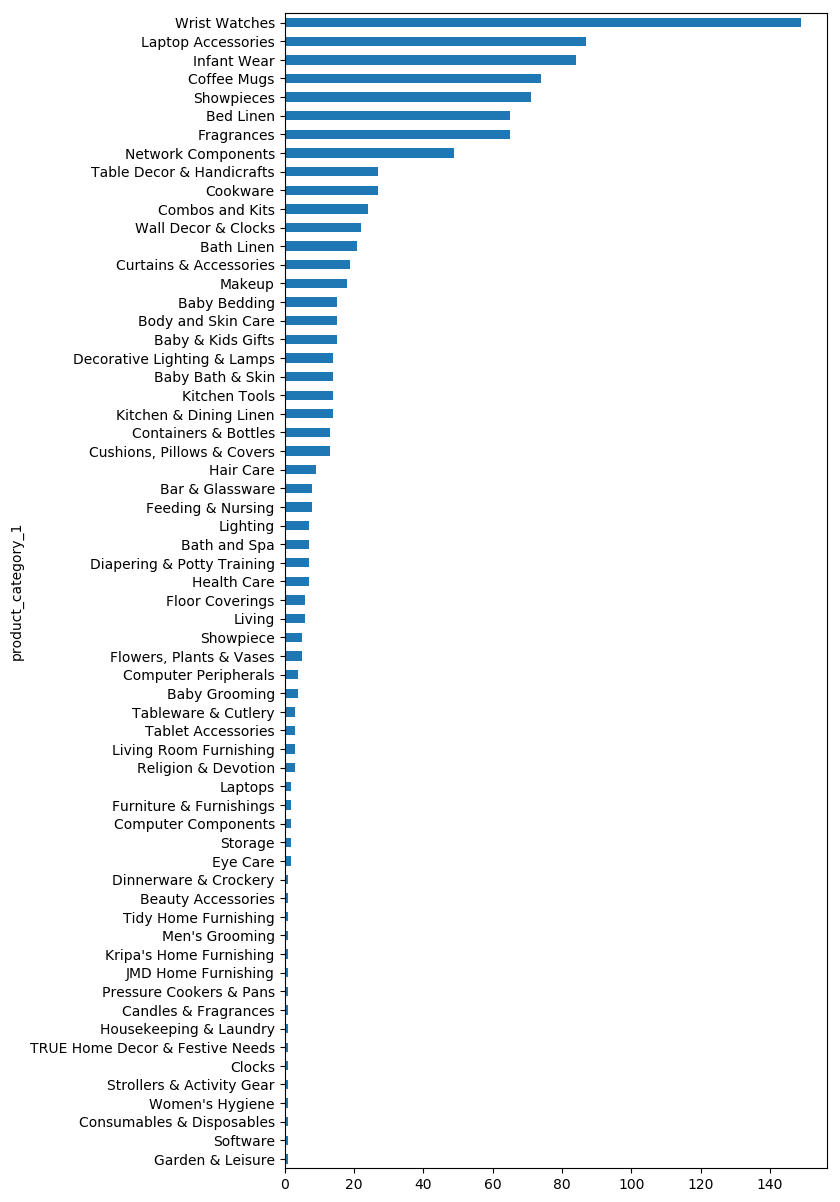

In [116]:
plt.figure(figsize=(7, 15))
data.groupby('product_category_1').size().sort_values().plot(kind='barh')

Au deuxième niveau de catégorisation, les catégories ne sont plus du tout équilibrées. Ceci suggère que les produits ont été choisis (aléatoirement?) de manière à ce que chaque catégorie de niveau 0 soit représentée également. On remarque également qu'un certain nombre de catégories ne concernent que très peu de produits (et même parfois un unique produit). Comment ces catégories de niveau 1 se répartissent-elles au sein des catégories de niveau 0?

In [117]:
for cat in data.product_category_0.unique():
    print(cat)
    print(data.loc[data["product_category_0"]==cat, "product_category_1"].value_counts())
    print('-'*20)
    print()

Home Furnishing
Bed Linen                     65
Bath Linen                    21
Curtains & Accessories        19
Kitchen & Dining Linen        14
Cushions, Pillows & Covers    13
Living                         6
Floor Coverings                6
Living Room Furnishing         3
JMD Home Furnishing            1
Kripa's Home Furnishing        1
Tidy Home Furnishing           1
Name: product_category_1, dtype: int64
--------------------

Baby Care
Infant Wear                   84
Baby Bedding                  15
Baby & Kids Gifts             15
Baby Bath & Skin              14
Feeding & Nursing              8
Diapering & Potty Training     7
Baby Grooming                  4
Furniture & Furnishings        2
Strollers & Activity Gear      1
Name: product_category_1, dtype: int64
--------------------

Watches
Wrist Watches    149
Clocks             1
Name: product_category_1, dtype: int64
--------------------

Home Decor & Festive Needs
Showpieces                         71
Table Decor & Ha

Les catégories de niveau 1 sont donc bien rattachées à une et une seule catégorie de niveau 0. En revanche, on remarque que certaines catégories de niveau 1 appartenant à des catégories de niveau 0 différentes se rapportent à des produits par ailleurs similaires. Par exemple, la sous-catégorie Clocks de la catégorie Watches contiendra probablement des produits similaires à la sous-catégorie Wall Decor & Clocks de la catégorie Home Decor & Festive Needs. Ceci expliquera en partie la difficulté à bien "séparer" les catégories d'objets si l'on se fonde uniquement sur ce système de catégories.

Dans la partie suivante, on va se concentrer sur les descriptions de produits, puisque ce sont elles qui vont nous permettre de réaliser la segmentation non-supervisée.

# II Nettoyage, normalisation et création du corpus
Pour extraire des caractéristiques intéressantes des descriptions on va utiliser les outils et méthodes standards du traitement automatisé du langage: tokenization, filtrage des tokens les plus fréquents, filtrage des tokens trop rares, et finalement lemmatisation. Une fois ces étapes réalisées on aura à notre disposition un corpus nettoyé et normalisé. Mais avant de procéder, la première étape va consister à vérifier que les descriptions sont bien rédigées dans la même langue, en l'occurence l'anglais. On utilise pour cela la bibliothèque langdetect
## II.1 Vérification du langage utilisé

On commence par écrire un petit script permettant de nettoyer le corpus des caractères spéciaux comme la tabulation, le retour chariot etc.

In [119]:
def clean_sample(sample):
    
    cleaned_sample = re.sub('\n|\r|\t', ' ', sample)
    cleaned_sample = re.sub('\s{2,}', ' ', cleaned_sample)
    
    return cleaned_sample

L'utilisation de cette bibliothèque est simple: il suffit d'appliquer la fonction detect_langs à un texte pour celle-ci renvoie un tuple ou une liste de tuples contenant la ou les langues détectées et la probabilité que la langue détectée soit bien la langue utilisée.  
On commence donc par créer une liste contenant les résultats associés à chaque description, puis on applique quelques traitements de mise en forme pour pouvoir visualiser les résultats sous la forme d'un pandas.DataFrame contenant 4 colonnes: première langue (c-à-d celle de probabilité la plus élevée), probabilité associée à cette langue, deuxième langue, probabilité associée à la deuxième langue. Il n'y a que 4 colonnes, car l'algorithme ne détecte jamais plus de deux langues différentes pour un texte donné dans notre cas.

In [120]:
# regroupement des résultats pour chaque description dans une liste
detected = list()
for sample in tqdm(data.description):
    cleaned_sample = clean_sample(sample)
    detected.append([(dl.lang, dl.prob) for dl in detect_langs(cleaned_sample)])

# création d'un dataframe contenant les résultats. Ce dataframe contient deux colonnes, et chaque colonne le tuple (langue, proba)
# pour chaque description.
raw_detected = pd.DataFrame(detected)

# La première colonne est extraite et convertie en un dataframe contenant deux colonnes: first_lang, first_prob
first_lang = pd.DataFrame.from_records(raw_detected[0].tolist(), columns=["first_lang", "first_prob"])

# Concaténation avec la deuxième colonne du dataframe initial. Le nouveau dataframe contient donc 3 colonnes.
d = pd.concat([first_lang, raw_detected[1]], axis=1)

# La plupart du temps, seule une langue est détectée. Dans ce cas la deuxième colonne ne contient pas un tuple, mais simplement None.
# On remplace None par (None, None) pour que le formattage coïncide avec les cas où une deuxième langue est détectée.
d[1] = d[1].apply(lambda x: (x, x) if x is None else x)

# Création du dataframe second_lang de manière similaire au dataframe first_lang
second_lang = pd.DataFrame.from_records(d[1].tolist(), columns=["second_lang", "second_prob"])

# Création du dataframe final
detected_languages = pd.concat([d.drop(columns=1), second_lang], axis=1)
detected_languages.head()

100%|██████████| 1050/1050 [00:15<00:00, 66.35it/s]


,first_lang,first_prob,second_lang,second_prob
0,en,0.999996,None,NaN
1,en,0.999996,None,NaN
2,en,0.999999,None,NaN
3,en,0.999995,None,NaN
4,en,0.999996,None,NaN


Les champs "_lang" ne sont pas forcément évidents à lire. On remplace par les noms de pays en utilisant les codes ISO pour les langages.

In [121]:
# ISO-codes for languages
wiki_page = pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes')
iso_codes = wiki_page[1][["ISO language name", "639-1"]]
iso_codes.head()

# Langages utilisés dans le dataset:
detected_languages["first_lang"] = (detected_languages.first_lang
 .apply(lambda x: iso_codes.loc[iso_codes["639-1"]==x, "ISO language name"].values[0])
)

detected_languages["second_lang"] = (detected_languages["second_lang"]
                                    .apply(lambda x: iso_codes.loc[iso_codes["639-1"]==x, "ISO language name"]
                                           .values[0] 
                                           if x else x)
                                    )

detected_languages.head()

,first_lang,first_prob,second_lang,second_prob
0,English,0.999996,None,NaN
1,English,0.999996,None,NaN
2,English,0.999999,None,NaN
3,English,0.999995,None,NaN
4,English,0.999996,None,NaN


On peut maintenant afficher les résultats. D'abord, quelles sont globalement les langues détectées dans les diverses descriptions?

In [122]:
print("Langue(s) principale(s) détectée(s): " + ", ".join([fl for fl in detected_languages.first_lang.unique()]))
print("Langue(s) secondaire(s) détectée(s): " + ", ".join([fl for fl in detected_languages.second_lang.unique() if fl]))

Langue(s) principale(s) détectée(s): English
Langue(s) secondaire(s) détectée(s): Italian, Indonesian, German


Comme attendu, l'anglais est la principale langue détectée dans les descriptions. Mais l'algorithme semble en avoir repéré d'autres. Est-ce pertinent, ou s'agit-il d'erreurs?

In [56]:
detected_languages[detected_languages.second_lang.notna()]

,first_lang,first_prob,second_lang,second_prob
197,English,0.714283,Italian,0.285716
267,English,0.428573,Indonesian,0.285713
1013,English,0.857139,German,0.142858


Il n'y a que trois occurences de deuxième langue détectée, alors même que l'anglais reste la langue la plus probable. On peut donc vérifier "à la main" la pertinence des ces résultats.

In [123]:
sample = data.iloc[197]["description"]
clean_sample(sample)

'Sam Rolling Pizza Cutter (Steel Pack of 1) Price: Rs. 45 Durable Good Quality Pizza Cutter Durable Good Quality Pizza Cutter'

In [124]:
sample = data.iloc[267]["description"]
clean_sample(sample)

'Sahara Q Shop Kadhai 1.5 L (Stainless Steel) Price: Rs. 650 Premium Non Stick Kadhai 1.5.Ltr Premium Non Stick Kadhai 1.5.Ltr'

In [125]:
sample = data.iloc[1013]["description"]
clean_sample(sample)

'Key Features of LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray - For Men Fragrance Classification: Deodorant Spray,LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray - For Men (210 ml) Price: Rs. 447 Lawman Deodorant Combo For Men,Specifications of LAWMAN PG3 Striker,, Winger , Contender Deodorant Spray - For Men (210 ml) Fragrance Traits Fragrance Classification Deodorant Spray Quantity 210 ml Ideal For Men In the Box 3 Deodorant'

Le détecteur de langue fonctionne bien la plupart du temps, c'est-à-dire qu'il reconnaît l'anglais comme la langue des descriptions. Dans quelques cas, le détecteur "croit" reconnaître d'autres langues, mais il s'agit manifestement de "faux" - d'ailleurs les probabilités associées sont plutôt basses comparé au 99%+ qu'on obtient généralement lorsqu'il n'y a pas d'ambiguité. L'ambiguité provient certainement de la présence de mots étrangers écrits avec l'alphabet latin (lorsque le détecteur s'attendrait à un autre alphabet, ou un autre langage utilisant l'alphabet latin).  
En conclusion: on va considérer qu'on n'a affaire qu'à de l'anglais dans ce dataset.

## II.2 Prétraitement

On utilise la bibliothèque NLTK pour réaliser les fonctions de tokenization, lemmatisation. On utilise les jeux de stop_words qui proviennent de NLTK et spaCy. Les fonctions qui réalisent ces opérations sont rassemblées dans le module textprocessing.

In [137]:
# création du set de stopwords
SW = set()
SW.update(nltk.corpus.stopwords.words('english'))
SW.update(STOP_WORDS)

# fonctions de lemmatization et tokenization
lemmatizer = WordNetLemmatizer()

# motif regex pour la tokenization. Ce motif filtre directement les caractères spéciaux comme 
# \n, \t \r etc., ainsi que les chiffres.
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')

**Démonstration de la tokenization sur un exemple**

In [135]:
s = data.description.sample(1).to_numpy()[0].lower()
print("Texte original")
print("-"*14)
s

Texte original
--------------


'craftartz buddha brass idol dhyan mudra showpiece  -  14 cm (brass, gold)\r\n                         price: rs. 999\r\n\t\t\t\t\r\n\t\t\tgive your home the feel of serenity with this brass sculpture of lord buddha, a god in hinduism buddhism. lord buddha, according to hindu mythology, is known to bring enlightenment to his believers and worshippers. buddha means "awakened one" or "the enlightened one." "buddha" is also used as a title for the first awakened being in an era. this is made of yellow brass metal which makes your home décor more vibrant.\r\nyou can place the statue at vantage points at home or office to draw inner strength. you can also install this statue at your home temple for performing puja and upasana in the hindu way. this idol is a fine work of art and also helps in enhancing your home décor. exquisite piece in brass, buddha can be used as home décor or in office. would make an excellent gift item during house warmings or on festive occassions. is an excellent cor

In [235]:
print("Après tokenization")
print("-"*18)
print(process_text(s))

Après tokenization
------------------
craftartz buddha brass idol dhyan mudra showpiece brass gold price home feel serenity brass sculpture lord buddha god hinduism buddhism lord buddha according hindu mythology known bring enlightenment believe wo ippe buddha mean awakened enlightened buddha title fi awakened era yellow brass metal make home cor vibrant place statue vantage point home office draw inner strength install statue home temple performing puja upasana hindu way idol fine work art help enhancing home cor exquisite piece brass buddha home cor office excellent gift item house warming festive occassions excellent corporate gift home feel serenity brass sculpture lord buddha god hinduism buddhism lord buddha according hindu mythology known bring enlightenment believe wo ippe buddha mean awakened enlightened buddha title fi awakened era yellow brass metal make home cor vibrant place statue vantage point home office draw inner strength install statue home temple performing puja upa

## II.3 Création du corpus

En appliquant ces fonctions de prétraitement à toutes les descriptions, on crée le corpus nettoyé et normalisé. 

In [14]:
tokenized_corpus = [process_text(desc.lower()) for desc in data.description]
tokenized_corpus = np.asarray(tokenized_corpus, dtype='object')

In [258]:
tokenized_corpus[0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack price curtain enhances look interio curtain high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart fi thing morning welcome bright sun ray want wish good morning world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filte light room right sunlight specification elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model abstract polyester door curtain set model id duster color multicolor dimension length box number content sale package pack sale package curtain body des

Maintenant que le corpus est créé, on va pouvoir créer les _features_ à partir desquelles on réalisera la segmentation. Dans un premier temps, et pour se familiariser un peu plus avec les données, on cherche à voir quels sont les mots les plus fréquemment associés à chacune des catégories. Est-ce que ces mots sont distincts, ou les retrouve-t-on dans plusieurs catégories?

## II.4 Analyse exploratoire: mots les plus fréquents

### II.4.1 Les 50 mots les plus fréquents

In [317]:
word_count = Counter()
for text in tokenized_corpus:
    for token in text.split(' '):
        word_count[token] += 1

word_count.most_common(50)

[('price', 561),
 ('mug', 457),
 ('feature', 404),
 ('online', 396),
 ('specification', 379),
 ('watch', 355),
 ('color', 334),
 ('type', 325),
 ('baby', 321),
 ('pack', 319),
 ('material', 313),
 ('set', 312),
 ('product', 300),
 ('cotton', 299),
 ('box', 297),
 ('general', 288),
 ('design', 273),
 ('package', 269),
 ('sale', 262),
 ('analog', 262),
 ('number', 253),
 ('warranty', 252),
 ('quality', 245),
 ('detail', 243),
 ('girl', 242),
 ('inch', 239),
 ('brand', 238),
 ('laptop', 236),
 ('best', 230),
 ('key', 228),
 ('model', 226),
 ('ceramic', 219),
 ('fabric', 211),
 ('showpiece', 207),
 ('size', 196),
 ('great', 189),
 ('boy', 184),
 ('perfect', 184),
 ('gift', 183),
 ('india', 180),
 ('dimension', 177),
 ('men', 177),
 ('skin', 175),
 ('usb', 174),
 ('x', 172),
 ('home', 170),
 ('ideal', 167),
 ('coffee', 164),
 ('multicolor', 160),
 ('content', 159)]

### II.4.2 Mots les plus fréquents par catégorie de produits

In [12]:
most_frequent = dict()
for cat in data.product_category_0:
    cat_indices = data[data.product_category_0==cat].index.tolist()
    word_count = Counter()
    for text in tokenized_corpus[cat_indices]:
        for token in text.split(' '):
            word_count[token] += 1
    most_frequent[cat] = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

In [13]:
print("mots les plus fréquents par catégorie de produit")
print("-"*50)
print()
for cat in data.product_category_0.unique():
    print(cat)
    print('-'*15)
    print(', '.join([m for m in list(zip(*most_frequent[cat]))[0][:20]]))
    print()

mots les plus fréquents par catégorie de produit
--------------------------------------------------

Home Furnishing
---------------
cotton, pack, cover, design, towel, cushion, inch, package, sale, polyester, color, material, single, price, feature, multicolor, curtain, width, blanket, floral

Baby Care
---------------
baby, girl, cotton, detail, fabric, boy, dress, specification, ideal, general, package, feature, sleeve, type, sale, neck, wash, number, pattern, content

Watches
---------------
watch, analog, men, online, india, great, discount, woman, dial, strap, boy, resistant, water, round, sonata, maximum, digital, girl, case, black

Home Decor & Festive Needs
---------------
showpiece, price, best, inch, wall, online, home, color, feature, brass, number, product, gift, art, material, box, dimension, beautiful, package, x

Kitchen & Dining
---------------
mug, ceramic, coffee, perfect, price, material, design, gift, ml, feature, specification, safe, product, pack, quality, loved,

Certains mots apparaissent dans plusieurs catégories de produit. Cela peut potentiellement nuire à la segmentation, il faudra voir comment les filtrer (ou les utiliser).
On peut regarder quels sont les mots parmi les 10 mots les plus utilisés qui reviennent dans plusieurs catégories

In [10]:
setlist = [set(list(zip(*most_frequent[cat]))[0][:10]) for cat in data.product_category_0]
set.intersection(*setlist)

set()

Aucun mot parmi les 10 plus fréquents de chaque catégorie n'apparaît dans toutes les catégories. A l'inverse, on peut regarder quels sont les mots qui reviennent dans chaque paire de catégorie.

In [14]:
intersect = []
for comb_cat in itertools.combinations(data.product_category_0.unique(), 2):
    setlist = [set(list(zip(*most_frequent[cat]))[0][:20]) for cat in comb_cat]
    intersect.append(set.intersection(*setlist))
multi_category_words = set(itertools.chain.from_iterable(intersect))
multi_category_words

{'best',
 'box',
 'boy',
 'color',
 'cotton',
 'design',
 'feature',
 'gift',
 'girl',
 'ideal',
 'inch',
 'material',
 'ml',
 'number',
 'online',
 'pack',
 'package',
 'price',
 'product',
 'quality',
 'sale',
 'skin',
 'specification',
 'type'}

Ces mots sont donc des mots qui sont fréquemment utilisés dans au moins deux catégories. On peut essayer de les supprimer, car ils contribuent à rendre les distinctions entre catégories moins nettes. On verra qu'en réalité, en utilisant TfidfVectorizer avec des paramètres bien choisis, ces mots peuvent être efficacement éliminés, ou au moins leur importance peut-être amoindrie lors de la construction des modèles.

# III Latent Semantic Analysis et évaluation des catégories originales

On va chercher dans cette partie à évaluer les catégories originales, c'est-à-dire à évaluer leurs scores de silhouette et de de Davies-Bouldin. L'intérêt de cette évaluation est de se donner une "baseline" qui permettra de comparer les catégories retrouvées de manière non-supervisée dans la partie suivante.  
Partant du corpus tokenisé, on commmence par calculer la matrice _document-term_ en appliquant l'algorithme TfIdfVectorizer. On peut, en ajustant un certain nombre de paramètres, procéder à une première réduction de dimension en éliminant les mots trop fréquents ou trop rares, ou encore filtrer ceux qui apparaissent dans trop de documents ou au contraire dans trop peu de documents. Ici, on ne va pas utiliser cette méthode mais réaliser une réduction de dimension en réalisant une Singular Value Decompositon (SVD) suivie d'une normalisation des vecteurs associés à chaque document. On utilisera ensuite l'algorithme t-SNE pour afficher les résultats dans un plan (en 2D donc), cet algorithme réalisera donc également une partie de la réduction de dimension. Comme la SVD et t-SNE dépendent d'un certain nombre de paramètres, on réalise une recherche sur grille (gridsearch) pour évaluer la meilleure combinaison de paramètres. Les scores sur lesquels cette recherche sur grille s'appuie pour réaliser l'évaluation sont le score de silhouette de de Davis-Bouldin comme indiqué ci-dessus.

## III.1 Processing pipeline
### III.1.1 Représentation "bag-of-words" - _Document-term matrix_

La fonction make_docterm_matrix permet de réaliser à la fois un filtrage sur la fréquence des mots dans l'ensemble du corpus, puis de réaliser la vectorisation de ce corpus grâce à l'algorithme TfIdfVectorizer. Il prend en entrée les paramètres de TfIdfVectorizer, et les paramètres min_tf (_min_ter frequency_) et max_tf (_max_term frequency_). On commence par montrer un exemple de matrice _document-term_ renvoyé par cette fonction.

In [15]:
tfidf, docterm = make_docterm_matrix(tokenized_corpus,
                              min_tf=10,
                              max_tf=400,
                              min_df=2,
                              max_df=0.5,
                              ngram_range=(1, 2)      
                                    )
pd.DataFrame(docterm, columns=tfidf.get_feature_names())

,absorbent,abstract,abstract art,abstract ceramic,abstract cushion,abstract design,abstract double,abstract eyelet,abstract floral,abstract single,...,yes model,yes organic,yes pot,yes type,yes warranty,yes yes,ym,ym analog,ym online,ym watch
0,0.0,0.165343,0.0,0.0,0.0,0.0,0.0,0.204911,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.050609,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1047,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1048,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Ici on a décidé de garder tous les unigrammes et les bigrammes. Les termes apparaissant moins de 10 fois, ou plus de 400 fois dans le corpus sont éliminés, ainsi que ceux apparaissant dans moins de 2 documents ou plus de 50% des documents du corpus. La matrice créée contient 3848 colonnes, c'est-à-dire 3848 unigrammes+bigrammes, et 1050 lignes ce qui correspond au nombre de produits dans le jeu de données. Dans la suite, toute la réduction dimensionnelle, c'est-à-dire essentiellement le filtrage des unigrammes/bigrammes que l'on souhaite garder sera laissée à la charge de la SVD. En réalite, la SVD va automatiquement créer des _features_ correspondant à des combinaisons d'unigrammes/bigrammes qui "captent" toute l'information contenue dans le jeu de données. On n'a donc pas en principe besoin de réaliser un filtrage des termes en amont, et on ne le fera pas dans cette partie.  

### III.1.2 Latent Semantic Analysis

La Latent Semantic Analysis (LSA) désigne simplement le processus consistant à vectoriser un corpus de textes, puis à leur appliquer une technique de réduction dimensionnelle appelée Singular Value Decomposition de manière à ne retenir que les _features_ les plus importantes. Par construction, ces _features_ sont des combinaisons des termes (lemmas) composant le corpus.  
Dans cette partie, on s'intéresse à la SVD appliquée à notre corpus. Comme il y a plus de termes que de documents (il y a 1050 documents dans le corpus pour un vocabulaire de plus de 4500 mots), le nombre maximal de composantes de la SVD est nécessairement égal au nombre de documents, donc 1050 ici. On inspecte l'allure de la courbe d'éboulis des valeurs propres pour se donner une idée du nombre de composantes à retenir. Dans la littérature, il est généralement recommandé de ne garder qu'une voire quelques centaines de composantes.

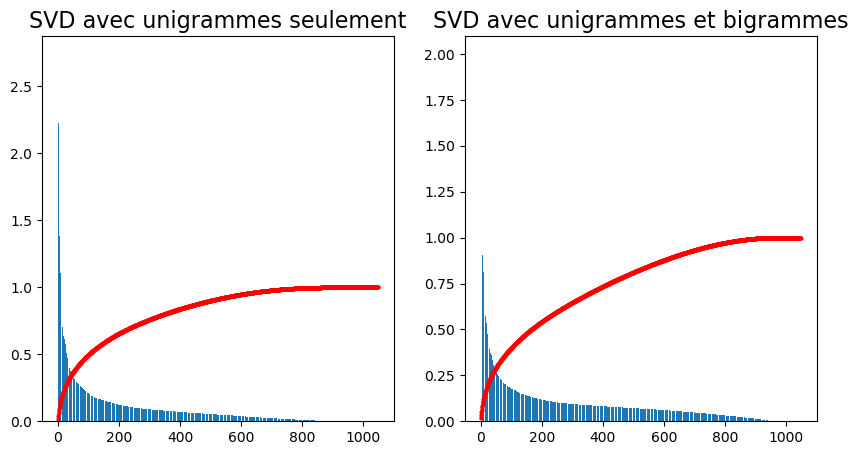

In [143]:
# création de la matrice 'bag_of_words'
_, docterm1 = make_docterm_matrix(tokenized_corpus, ngram_range=(1, 1))
svd1 = decomposition.TruncatedSVD(n_components=1050).fit(docterm1)

_, docterm2 = make_docterm_matrix(tokenized_corpus, ngram_range=(1, 2))
svd2 = decomposition.TruncatedSVD(n_components=1050).fit(docterm2)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
svd_var_ratio1 = svd1.explained_variance_ratio_
ax1.bar(np.arange(1050), 100*svd_var_ratio1)
ax1.plot(np.arange(1050), svd_var_ratio1.cumsum(), c='red', marker='o', markersize=2)
ax1.set_title('SVD avec unigrammes seulement', fontsize=16)

svd_var_ratio2 = svd2.explained_variance_ratio_
ax2.bar(np.arange(1050), 100*svd_var_ratio2)
ax2.plot(np.arange(1050), svd_var_ratio2.cumsum(), c='red', marker='o', markersize=2)
ax2.set_title('SVD avec unigrammes et bigrammes', fontsize=16)
plt.show()

La dernière partie du processus est composée d'une visualisation par t-SNE, un algorithme permettant de visualiser des données de grandes dimensions dans un plan (2D) ou l'espace 3D.

## III.2 Evaluation des paramètres optimaux par _gridsearch_

On réalise une recherche sur grille (gridsearch) pour déterminer la combinaison de paramètres (nb de composantes de la SVD, perplexité et nb d'itérations pour t-SNE) optimale. Cette recherche est coûteuse en ressources, notamment en temps puisqu'elle prend environ 1/2h. Ainsi, les résultats de cette recherche ont été enregistrés dans un fichier csv qu'on va importer pour pouvoir les visualiser sans avoir à relancer la _gridsearch_ à chaque fois.  
Pour la visualisation, on utilise la fonction plot_gs_results qui permet d'afficher les résultats de la recherche sous forme de plusieurs plots représentant chacun en abscisse l'un de paramètres et en ordonnée le score permettant l'évaluation (ici silhouette ou Davies-Bouldin)

In [ ]:
#grid = {"n_components": [800, 400, 200, 100], 
#        "perplexity":[100, 50, 30, 10], 
#        "n_iterations":[4000],
#        "ngram_range":[(1, 1), (1, 2)]
#       }
#
#results = custom_gridsearch(tokenized_corpus, grid, method='tsne', labels=data.product_category_0, verbose=2)
#
#tsne_gs_results = pd.DataFrame(results, columns=["n_components",
#                                                 "perplexity",
#                                                 "n_iterations",
#                                                 "ngram_range",
#                                                 "silhouette_score",
#                                                 "davies_bouldin_score"])
#
#tsne_gs_results["ngram_range"] = tsne_gs_results["ngram_range"].apply(lambda x: 0 if x==(1, 1) else 1)
#
## Enregistrement des résultats dans un fichier csv
#tsne_gs_results.to_csv('./tsne_gs_results.csv', index_label=False)

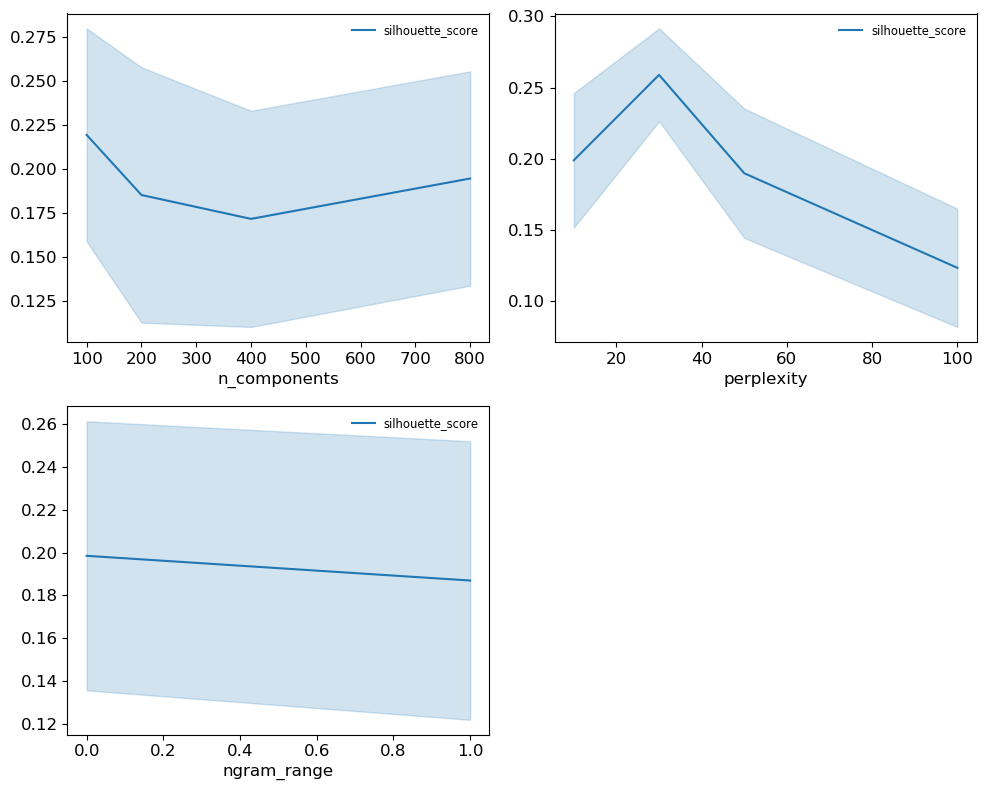

In [748]:
tsne_gs_results = pd.read_csv('./tsne_gs_results.csv')
grid_keys = [
    "n_components",
    "perplexity",
    "ngram_range"
]

score = [
    ["silhouette_score"],
    ["davies_bouldin_score"]
]

plot_gs_results(tsne_gs_results, score[0], plot_param=grid_keys, axis_scale='linear')

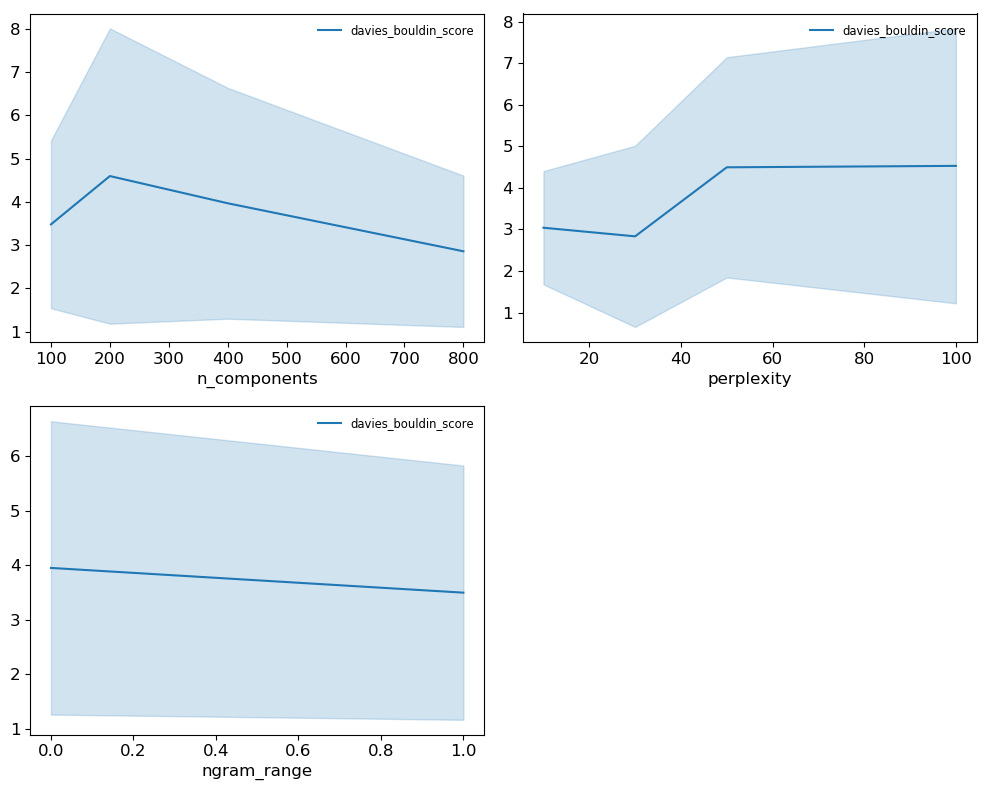

In [151]:
plot_gs_results(tsne_gs_results, score[1], plot_param=grid_keys, axis_scale='linear')

In [760]:
best_silh = tsne_gs_results.silhouette_score.max()
best_dbs = tsne_gs_results["davies_bouldin_score"].min()
print("Meilleurs scores:\tscore de silhouette\tscore de Davies-Bouldin\n\t\t\t{:.3f}\t\t\t{:.3f}"
      .format(best_silh, best_dbs))

Meilleurs scores:	score de silhouette	score de Davies-Bouldin
			0.297			1.523


On remarque que les scores ne sont pas très bons: ceci suggère que les catégories sont mal définies, c'est-à-dire qu'elles ne sont ni très homogènes, ni très distinctes. On peut aller un peu plus loin, et afficher la représentation des catégories par t-SNE en utilisant les paramètres optimaux déterminés par _gridsearch_, et afficher les scores de silhouettes détaillés.

In [751]:
# On remplace les valeurs 0 et 1 pour ngram_range par les "vraies" valeurs: (1, 1) et (1, 2)
tsne_gs_results['ngram_range'] = tsne_gs_results['ngram_range'].apply(lambda x: (1, 1) if x==0 else (1, 2))

best_params_silh = tsne_gs_results.loc[tsne_gs_results["silhouette_score"]==best_silh, grid_keys].to_dict('r')[0]
best_params_dbs = tsne_gs_results.loc[tsne_gs_results["davies_bouldin_score"]==best_dbs, grid_keys].to_dict('r')[0]

## III.3 Résultats

### III.3.1 Encodage des "vraies" catégories

In [226]:
# Encodage numérique des vraies catégories
le = preprocessing.LabelEncoder()
labels_0 = le.fit_transform(data.product_category_0)
data['label_0'] = labels_0

# Encodage numérique des vraies catégories
le1 = preprocessing.LabelEncoder()
labels_1 = le1.fit_transform(data.product_category_1)
data['label_1'] = labels_1

### III.3.2 Affichage des résultats

**Paramètres optimisés pour le score de silhouette**

In [752]:
# On construit un nouveau modèle en utilisant les paramètres optimaux
best_ngram = best_params_silh.pop('ngram_range')
_, docterm = make_docterm_matrix(tokenized_corpus, idf_transform=True, ngram_range=best_ngram)

lsa_tsne = create_lsa_tsne_pipeline(**best_params_silh)
X_tsne = lsa_tsne.fit_transform(docterm)
#X_tsne = pd.DataFrame(data=X_tsne, columns=["t-SNE 0", "t-SNE 1"])

In [753]:
best_params_silh

{'n_components': 100, 'perplexity': 30}

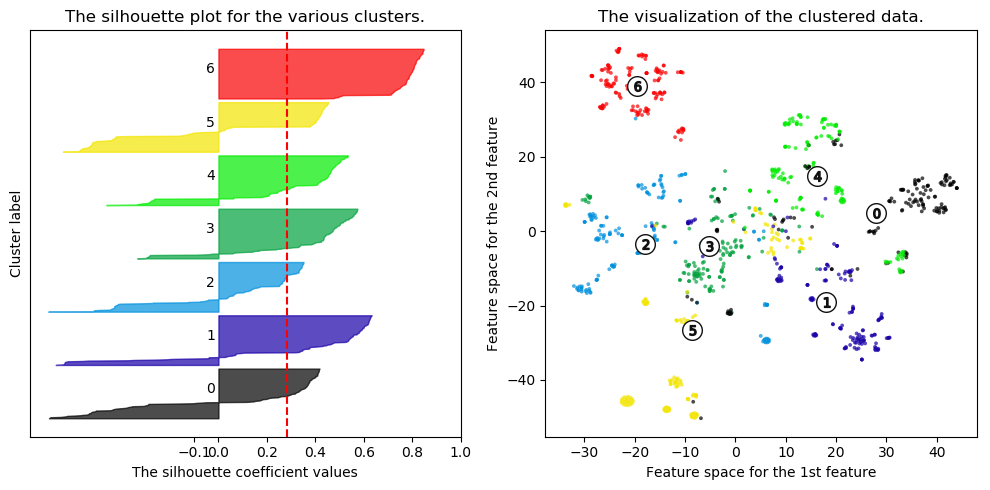

In [754]:
# On affiche les résultats
plot_silhouette_analysis(X_tsne, data, "label_0")

**Paramètres optimisés pour le score de Davies-Bouldin**

In [ ]:
# On construit un nouveau modèle en utilisant les paramètres optimaux
best_ngram = best_params_dbs.pop('ngram_range')
_, docterm = make_docterm_matrix(tokenized_corpus, idf_transform=True, ngram_range=best_ngram)

lsa_tsne = create_lsa_tsne_pipeline(**best_params_dbs)

In [758]:
X_tsne = lsa_tsne.fit_transform(docterm)
#X_tsne = pd.DataFrame(data=X_tsne, columns=["t-SNE 0", "t-SNE 1"])

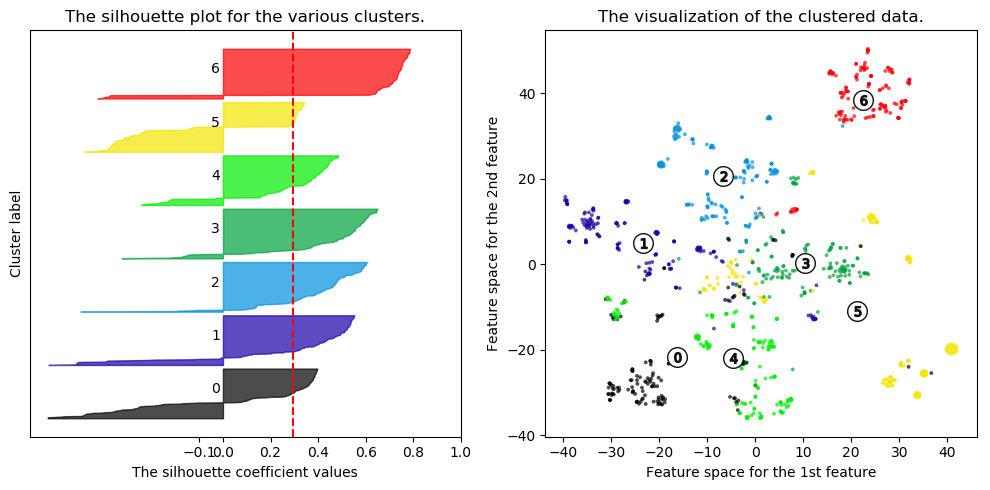

In [759]:
# On affiche les résultats
plot_silhouette_analysis(X_tsne, data, "label_0")

**2. Evaluation des catégories de niveau 1**

Pour évaluer les scores sur les catégories de niveau 1, on ne réitère pas toute la procédure avec la recherche sur grille, mais on évalues simplement les scores de silhouette et de Davies-Bouldin en prenant comme étiquettes les nouvelles catégories.

In [233]:
silh = metrics.silhouette_score(X_tsne, labels_1)
dbs = metrics.davies_bouldin_score(X_tsne, labels_1)
print("Scores obtenus avec les catégories de niveau 1:\tscore de silhouette\tscore de Davies-Bouldin\n\t\t\t\t\t\t{:.3f}\t\t\t{:.3f}"
      .format(silh, dbs))

Scores obtenus avec les catégories de niveau 1:	score de silhouette	score de Davies-Bouldin
						0.082			4.563


Bien qu'ils soient établis avec des paramètres qui ne sont pas optimisés pour ces catégories-là, les scores obtenus conduisent à ne pas prendre en compte ces catégories dans la suite. On indique également que lorsqu'ils sont évalués à partir de modèles optimisés, les scores sont à peine meilleurs: de l'ordre de 0.11 pour le score de silhouette, et 3.5 pour le score de Davies-Bouldin.

# IV Apprentissage non-supervisé de catégories

Dans cette partie, on va tenter de segmenter de façon non-supervisée les produits grâce à leurs descriptions. Pour cela, on va comme précédemment utiliser le corpus nettoyé et vectorisé que l'on va ensuite donner en entrée d'un algorithme de clustering. Trois méthodes sont explorées dans la suite:
- La Latent Dirichlet Allocation LDA
- Kmeans
- HDBSCAN

Dans le premier cas (LDA), la réduction dimensionnelle est uniquement réalisée par le vectorisateur TfIdfVectorizer, tandis que dans les deux autres cas, une LSA est d'abord réalisée (comme précédemment)

Dans chaque cas, on cherchera à évaluer _absolument_ les clusters formés, c'est-à-dire en évaluant leurs scores de silhouette de de Davies-Bouldin. Cela permettra de comparer les scores obtenus à ceux obtenus ci-dessus pour les catégories originales. On cherchera également à évaluer ces clusters _relativement_ aux catégories originales, en utilisant l'indice de Rand ajusté (adjusted Rand Index).

## IV.1 LDA pipeline

### IV.1.1 Recherche des meilleurs paramètres pour LDA

On réalise à nouveau une recherche sur grille pour déterminer les paramètres optimaux d'une LDA. Le score utilisé pour évaluer le meilleur modèle est le log-likelihood, qu'on cherche à maximiser. Ceci permet de réaliser une évaluation intrinsèque du modèle, sans référence aux catégories données par Flipkart et explorées précédemment. Les résultats de cette recherche ont été au préalable sauvegardés dans un le fichier LDA_gs_results.csv. On commence donc par importer ce fichier.

### Note à propos des paramètres doc_topic_prior et topic_word_prior

Depuis: [Topic Model Evaluation in Python with tmtoolkit | WZB Datascience Blog](https://datascience.blog.wzb.eu/2017/11/09/topic-modeling-evaluation-in-python-with-tmtoolkit/)  
"Besides the number of topics, there are also the alpha and beta (sometimes eta in literature) parameters. Both are used to define Dirichlet priors that are used in the calculations for the respective posterior distributions. Alpha is the “concentration parameter” for a prior over the document-specific topic distributions and beta for a prior over the topic-specific word distributions. Both specify prior beliefs about the sparsity/homogeneity of topics and words in the corpus.

Alpha plays a role in the sparsity of topics in the documents. A high alpha value means a lower impact of topic sparsity, i.e. it is expected that a document contains a mixture of most topics, whereas a low alpha value means that we expect documents to cover only a few topics. This is also why alpha is often set to a fraction of the number of topics (like 1/k in our evaluations): With more topics to discover, we expect that each document will contain fewer, but more specific topics. As extreme examples: If we wanted to discover only two topics (k=2) then it is very likely that all documents contain both topics (to a different amount) and hence we have a large value of alpha=1/2. If we wanted to discover k=1000 topics, it is very likely that most of the documents will not cover all of the 1000 topics but only a small fraction of them (i.e. the sparsity is high) and hence we take a low value of alpha=1/1000 to account for this expected sparsity.

Likewise, beta plays a role in the sparsity of words in the topics. A high beta value means a lower impact of word sparsity, i.e. we expect that each topic will contain most of the words of the corpus. These topics will be more “general” and their word probabilities will be more uniform. A low beta value means the topics should be more specific, i.e. their word probabilities will be less uniform, placing higher probabilities on fewer words. Of course this is also connected to the number of topics to be discovered. A high beta means that few, but more general topics are to be discovered, a low beta should be used for a larger amount of topics which are more specific. Griffiths and Steyvers explain that beta “affects the granularity of the model: a corpus of documents can be sensibly factorized into a set of topics at different scales […]. [A] large value of beta would lead the model to find a relatively small number of topics […] whereas smaller values of beta will produce more topics.” "

In [482]:
#grid = {"min_tf" : [2, 10, 30],
#        "max_tf" : [None, 400],
#        "min_df" : [2, 5, 10],
#        "max_df" : [0.5, 0.95],
#        "n_topics" : [7],
#        "doc_topic_prior" : [1/2, None],
#        "topic_word_prior" : [1/70, None, 1/2]
#        }

#lda_gs_results = custom_gridsearch(tokenized_corpus, grid, labels=labels_0, method='lda', ari=True, verbose=2)

# Transforme les valeurs 'None' en leur valeur réelle
#max_freq = max(word_freq(tokenized_corpus).values())
#lda_gs_results["max_tf"].fillna(max_freq, inplace=True)
#lda_gs_results["doc_topic_prior"].fillna(1/lda_gs_results["n_topics"], inplace=True)
#lda_gs_results["topic_word_prior"].fillna(1/lda_gs_results["n_topics"], inplace=True)

#lda_gs_results.to_csv('./LDA_gs_results.csv', index_label=False)


# On charge directement les résultats de la recherche sur grille
lda_gs_results = pd.read_csv('./LDA_gs_results.csv')
lda_gs_results.sort_values(by='score', ascending=False)

,doc_topic_prior,max_df,max_tf,min_df,min_tf,n_topics,topic_word_prior,score
41,0.500000,0.50,400.0,5,10,7,0.500000,0.458707
5,0.500000,0.50,561.0,2,10,7,0.500000,0.449621
215,0.142857,0.95,400.0,10,30,7,0.500000,0.448324
47,0.500000,0.50,400.0,10,2,7,0.500000,0.427034
50,0.500000,0.50,400.0,10,10,7,0.500000,0.416937
...,...,...,...,...,...,...,...,...
54,0.500000,0.95,561.0,2,2,7,0.014286,0.152653
190,0.142857,0.95,400.0,2,2,7,0.142857,0.140355
189,0.142857,0.95,400.0,2,2,7,0.014286,0.136392
0,0.500000,0.50,561.0,2,2,7,0.014286,0.130583


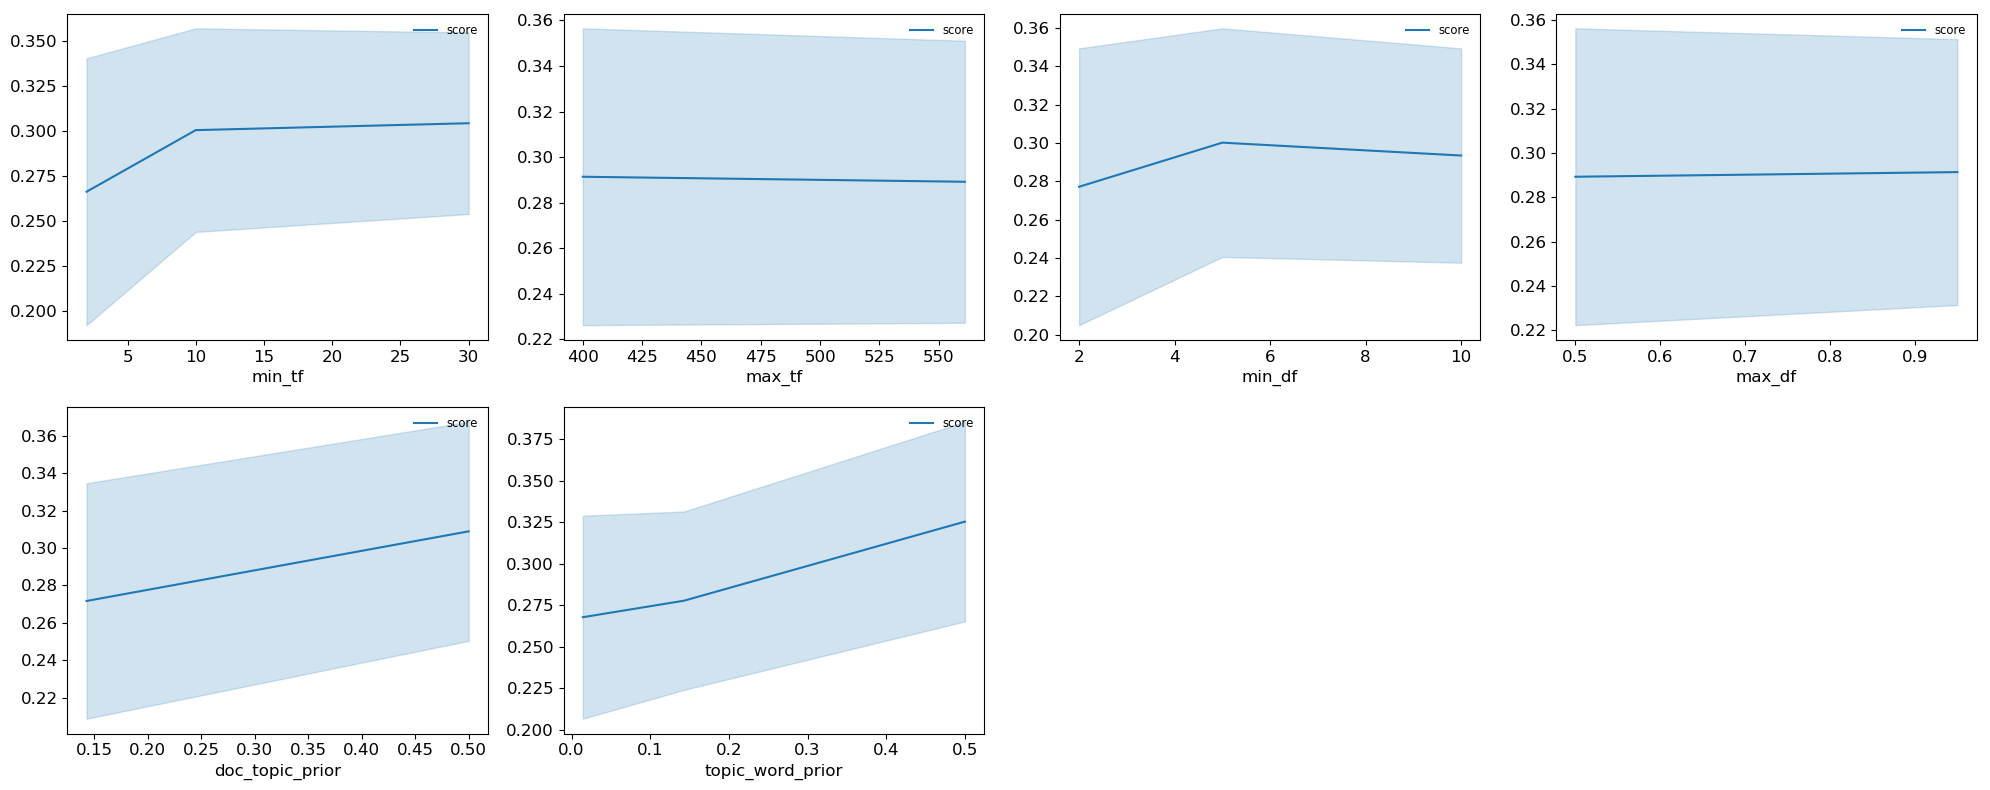

In [373]:
grid_keys = [
    "min_tf",
    "max_tf",
    "min_df", 
    "max_df",
    "doc_topic_prior",
    "topic_word_prior"
]

score = ["score"]
plot_gs_results(lda_gs_results, score, plot_param=grid_keys, axis_scale='linear')

On enregistre les meilleurs paramètres dans un dictionnaire - à l'exception du score

In [483]:
max_ari = lda_gs_results['score'].max()
best_params_lda = lda_gs_results.loc[lda_gs_results['score']==max_ari, list(grid.keys())].to_dict('r')[0]
best_params_lda

{'min_tf': 10,
 'max_tf': 400.0,
 'min_df': 5,
 'max_df': 0.5,
 'n_topics': 7,
 'doc_topic_prior': 0.5,
 'topic_word_prior': 0.5}

### IV.1.2 Pipeline et évaluation des thèmes latents

On va maintenant chercher à "découvrir" les thèmes latents du jeu de données grâce à l'algorithme LDA. L'algorithme LDA prend en entrée une matrice document-term telle qu'obtenue par application du vetorisateur TfIdfVectorizer par exemple.

Après avoir réalisé l'évaluation par LDA, on cherchera à comparer les résultats avec la catégorisation "native" grâce au score de Rand ajusté (Adjusted Rand Index). On visualisera également les différents thèmes trouvés grâce à pyLDAvis, et on calculera la matrice de confusion ainsi que le rapport de classification pour avoir une vue plus précise du résultat de la segmentation.

**1. Création de la matrice document-terme et recherche des topics par LDA avec les meilleurs paramètres en entrée**

In [456]:
# création de la matrice 'bag_of_words'
tfidf, docterm = make_docterm_matrix(tokenized_corpus, min_tf=2, min_df=10, max_tf=None, max_df=0.5)

n_topics = 7

# Créer le modèle LDA
lda = decomposition.LatentDirichletAllocation(
    n_components=n_topics, 
    max_iter=100,
    learning_method='batch',
    doc_topic_prior=best_params_lda["doc_topic_prior"],
    topic_word_prior=best_params_lda["topic_word_prior"]
)

# Fitter sur les données - on utilise la matrice "bag-of-words"
lda.fit(docterm)

On sauvegarde le modèle:

In [462]:
with open('tfidf_LDA_model.pickle', 'wb') as f:
    pickle.dump(tfidf, f)

with open('docterm_LDA_array.pickle', 'wb') as f:
    pickle.dump(docterm, f)

with open('LDA_model.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(lda, f)

**2. Affichage des topics par mots les plus importants**

In [468]:
# affichage des mots les plus représentatifs
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

no_top_words = 10
tf_feature_names = tfidf.get_feature_names()
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
watch analog men india great woman discount online dial boy

Topic 1:
set combo online kadhai skin hair kit soap trait shape

Topic 2:
mug ceramic coffee gift perfect ml sticker design prithish bottle

Topic 3:
single abstract double blanket quilt multicolor red lowest comforte floral

Topic 4:
usb warranty light laptop led battery router wireless cell power

Topic 5:
showpiece best towel online bath wall brass cotton handicraft art

Topic 6:
baby pack girl cotton color box detail specification type fabric



**3. Visualisation avec pyLDAvis**

Chargement du modèle LDA

In [464]:
#with open('tfidf_LDA_model.pickle', 'rb') as f:
#    tfidf = pickle.load(f)

#with open('docterm_LDA_array.pickle', 'rb') as f:
#    docterm = pickle.load(f)

#with open('LDA_model.pickle', 'rb') as f:
#    lda = pickle.load(f)

In [467]:
pyLDAvis.sklearn.prepare(lda, docterm, tfidf)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.088733  0.175129       1        1  23.621955
2     -0.048092 -0.069635       2        1  14.825625
0      0.215241  0.045179       3        1  14.178759
4     -0.036182 -0.052346       4        1  13.220263
5     -0.007541 -0.046160       5        1  12.200212
1     -0.002438 -0.048905       6        1  11.441063
3     -0.032254 -0.003262       7        1  10.512124, topic_info=          Term       Freq      Total Category  logprob  loglift
417        set  35.000000  35.000000  Default  30.0000  30.0000
500      watch  35.000000  35.000000  Default  29.0000  29.0000
88       combo  30.000000  30.000000  Default  28.0000  28.0000
425  showpiece  29.000000  29.000000  Default  27.0000  27.0000
12      analog  30.000000  30.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
107      craft   1.986100   5.558725   Topic7  -5.1537   1.2234
166       face   1.795248   5.254982   Topic7  -5.2548   1.1786
205      green   2.661774   8.900611   Topic7  -4.8609   1.0455
51       brown   2.263366   8.718352   Topic7  -5.0230   0.9041
228       home   2.505885  11.038820   Topic7  -4.9213   0.7699

[269 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         7  0.812870  abstract
1         1  0.165653        ac
1         4  0.496958        ac
4         4  0.762921   adapter
5         2  0.521979       add
...     ...       ...       ...
511       4  0.716875  wireless
512       3  0.856483     woman
513       5  0.587838      wood
514       5  0.540259    wooden
518       2  0.557115       yea

[358 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 1, 5, 6, 2, 4])

**4. Evaluations de la segmentation**
1. Evaluation relative aux "vraies" catégories

In [465]:
# Assignation des catégories à chaque produit: la catégorie retenue est celle pour laquelle la proba est maximale
X_topics = lda.transform(docterm)
topics = np.argmax(X_topics, axis=1)
data["LDA_topic"] = topics

In [466]:
eval_clustering(data.label_0, topics, text='LDA')

ARI entre les étiquettes obtenues par LDA et les vraies étiquettes: 0.42


2. Inspection de la matrice de confusion

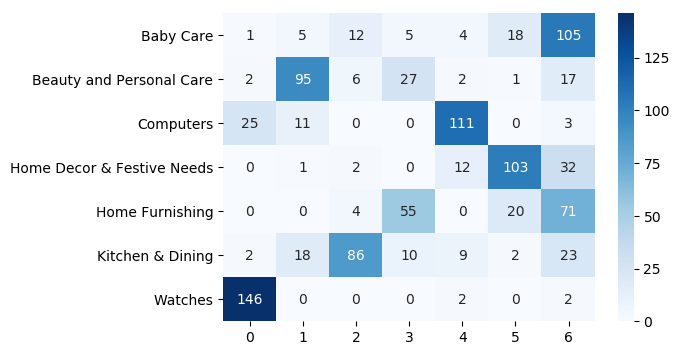

In [485]:
label_classes = np.unique(le.inverse_transform(labels_0))

conf_mat = metrics.confusion_matrix(labels_0, topics)

df_cm = pd.DataFrame(conf_mat, index = [label for label in np.unique(label_classes)],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.0f')
plt.show()

On réorganise les colonnes pour associer les étiquettes trouvées aux étiquettes originales: on associe à une ligne donnée la colonne pour laquelle le nombre d'éléments est maximal. En cas de conflit, si par exemple deux colonnes doivent être associées à la même ligne selon cette logique, on associe prioritairement la colonne possédant le plus grand nombre d'éléments.

Correspondance des clusters :  [6 1 5 4 2 3 0]


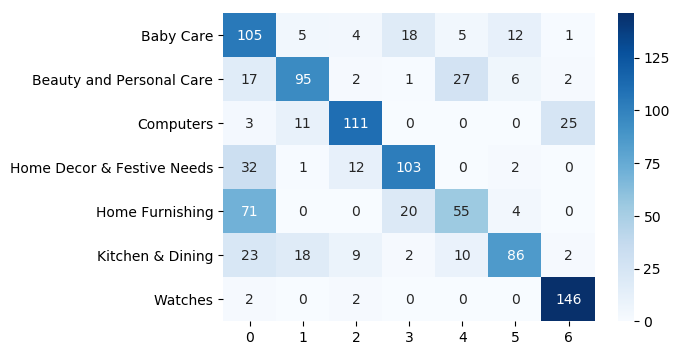

In [486]:
labels_transform = conf_mat_transform(labels_0, topics)
conf_mat = metrics.confusion_matrix(labels_0, labels_transform)
df_cm = pd.DataFrame(conf_mat, index = [label for label in np.unique(label_classes)],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.0f')
plt.show()

In [475]:
print(metrics.classification_report(labels_0, labels_transform))

              precision    recall  f1-score   support

           0       0.42      0.70      0.52       150
           1       0.73      0.63      0.68       150
           2       0.79      0.74      0.77       150
           3       0.72      0.69      0.70       150
           4       0.57      0.37      0.45       150
           5       0.78      0.57      0.66       150
           6       0.83      0.97      0.90       150

   micro avg       0.67      0.67      0.67      1050
   macro avg       0.69      0.67      0.67      1050
weighted avg       0.69      0.67      0.67      1050



En gardant en tête les définitions suivantes:
- recall (sensibilité): taux de vrais positifs, c'est-à-dire la proportion de positifs correctement identifiés. recall = TP / TP + FN
- precision: taux de prédictions correctes parmi les "positifs". precision = TP / TP + FP
- spécificité: taux de vrais négatifs. specificité = TN / TN + FP
- F-mesure est la moyenne harmonique de la precision et du recall

D'après le rapport de classification, les catégories les mieux identifiées par LDA (celles combinant haute précision et haut rappel) sont les catégories "Watches", "Computers", "Home Decor & Festive Needs", "Beauty & Personal Care", "Kitchen & Dining", "Baby Care". "Home furnishing" n'est pas bien identifiée comme en attestent les faibles scores de précision et de rappel.

Dans notre contexte, on cherche à mettre en place un classificateur dont on souhaiterait qu'il identifie correctement un produit. Est-ce plus important d'identifier correctement tous les produits appartenant à une classe, quitte à inclure dans cette classe des objets qui n'y appartiennent pas? Ou préfère-t-on minimiser le nombre de produits incorrectement catégorisés, quitte à ne pas pouvoir catégoriser automatiquement tous les produits?

## IV.2 K-Means pipeline

On reprend une démarche similaire à celle utilisée pour la LDA, cette fois avec KMeans. Ici, le pipeline est consitué d'une _latent semantic analysis_ suivie d'une segmentation par K-Means, et pour terminer une visualisation par t-SNE. 

Le rapport de classification sera utilisé comme dans le cas de la LDA, de manière à pouvoir comparer les résultats.

**1. Réduction dimensionnelle par SVD (Latent Semantic Analysis) et Segmentation avec K-Means** 

In [492]:
# création de la matrice 'bag_of_words'
tfidf, dtm = make_docterm_matrix(tokenized_corpus)

# Latent semantic analysis
lsa = pipeline.make_pipeline(decomposition.TruncatedSVD(n_components=100),
                                    preprocessing.Normalizer(copy=False)
                            )

X_lsa = lsa.fit_transform(dtm)

# K-means
km = cluster.KMeans(n_clusters=7,init="k-means++",max_iter=100,n_init=10)
km.fit(X_lsa)

# t-SNE
tsne = manifold.TSNE(perplexity=30, n_iter=4000)
X_tsne = tsne.fit(X_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Sauvegarde du modèle

In [ ]:
with open('tfidf_lsa_model.pickle', 'wb') as f:
    pickle.dump(tfidf, f)

with open('X_lsa_array.pickle', 'wb') as f:
    pickle.dump(X_lsa, f)

with open('lsa_model.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(lsa, f)
    
with open('kmeans_model.pickle', 'wb') as f:
    pickle.dump(km, f)

In [804]:
with open('tsne_model.pickle', 'wb') as f:
    pickle.dump(tsne, f)

**3. Affichage des topics générés**

In [494]:
original_space_centroids = lsa.named_steps["truncatedsvd"].inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = pd.DataFrame(dtm, columns=tfidf.get_feature_names()).columns

for i in range(7):
    print("Cluster {}: ".format(i))
    print(" ".join([terms[ind] for ind in order_centroids[i, :10]]))
    print()

Cluster 0: 
usb kadhai light led best hub fan online port portable

Cluster 1: 
mug ceramic coffee prithish perfect rockmantra gift design loved safe

Cluster 2: 
towel inch cotton pack single blanket set multicolor laptop box

Cluster 3: 
watch analog men discount india great woman online dial boy

Cluster 4: 
combo set online denver yardley adidas deo playboy nike ice

Cluster 5: 
baby girl detail fabric cotton dress boy sleeve neck ideal

Cluster 6: 
showpiece best online handicraft brass statue golmaalshop gift buddha ganesha



**4. Visualisation avec t-SNE**

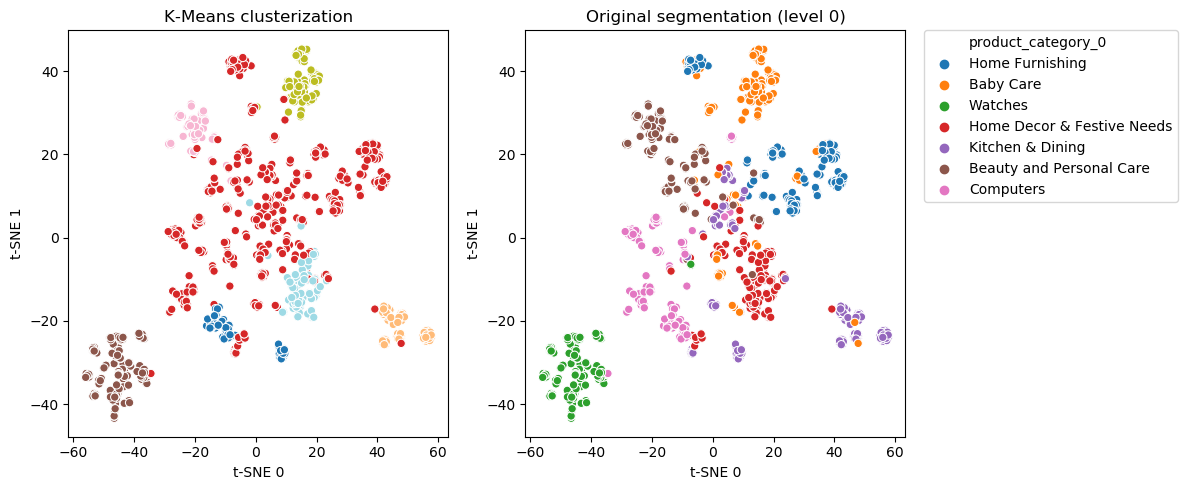

In [495]:
X_tsne = tsne.embedding_
data["km_label"] = km.labels_
visualize_tsne(data, X_tsne, "km_label")

**5. Evaluation de la segmentation**

1. Relative aux "vraies" catégories

In [358]:
eval_clustering(data.label_0, km.labels_)

ARI entre les étiquettes obtenues par LDA et les vraies étiquettes: 0.30


2. Inspection de la matrice de confusion

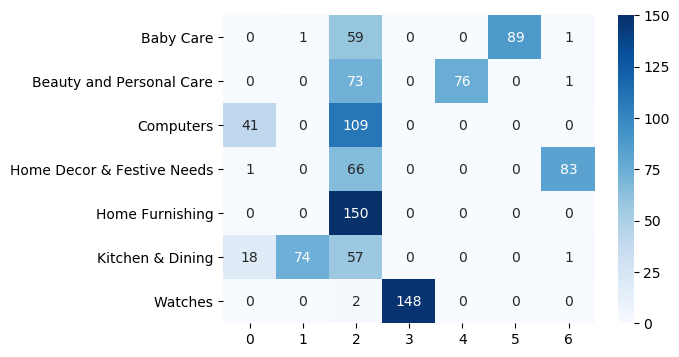

In [496]:
label_classes = np.unique(le.inverse_transform(labels_0))
conf_mat = metrics.confusion_matrix(labels_0, data.km_label)
df_cm = pd.DataFrame(conf_mat, index = [label for label in np.unique(label_classes)],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.0f')
plt.show()

On réorganise les colonnes pour associer les étiquettes trouvées aux étiquettes originales: on associe à une ligne donnée la colonne pour laquelle le nombre d'éléments est maximal. En cas de conflit, si par exemple deux colonnes doivent être associées à la même ligne selon cette logique, on associe prioritairement la colonne possédant le plus grand nombre d'éléments.

Correspondance des clusters :  [2 5 4 6 1 0 3]


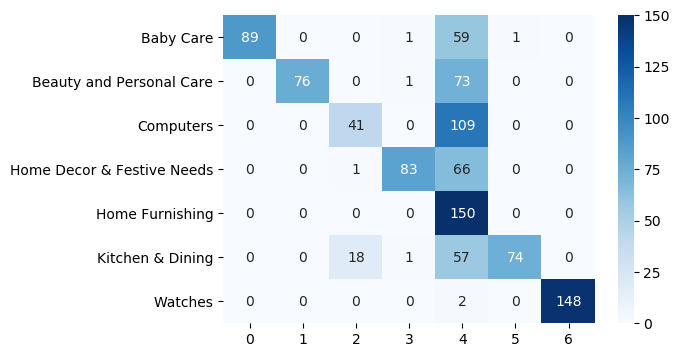

In [497]:
labels_transform = conf_mat_transform(labels_0, data.km_label)
conf_mat = metrics.confusion_matrix(labels_0, labels_transform)
df_cm = pd.DataFrame(conf_mat, index = [label for label in np.unique(label_classes)],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.0f')
plt.show()

In [498]:
print(metrics.classification_report(labels_0, labels_transform))

              precision    recall  f1-score   support

           0       1.00      0.59      0.74       150
           1       1.00      0.51      0.67       150
           2       0.68      0.27      0.39       150
           3       0.97      0.55      0.70       150
           4       0.29      1.00      0.45       150
           5       0.99      0.49      0.66       150
           6       1.00      0.99      0.99       150

   micro avg       0.63      0.63      0.63      1050
   macro avg       0.85      0.63      0.66      1050
weighted avg       0.85      0.63      0.66      1050



2. Evaluation absolue par la méthode du coude

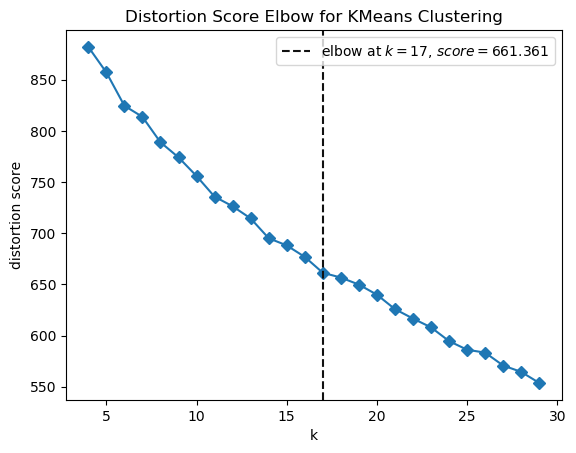

In [359]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,30), timings=False
)

visualizer.fit(X_lsa)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

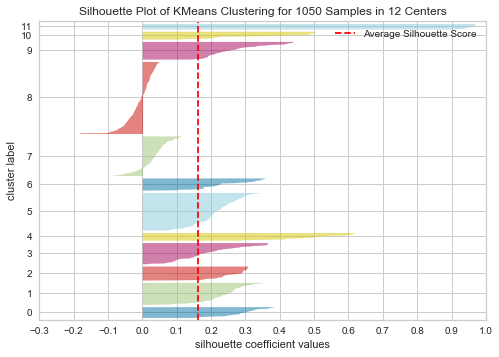

In [892]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans(12, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_lsa)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [360]:
km = cluster.KMeans(
        n_clusters=17,
        init="k-means++",
        max_iter=100,
        n_init=10,
    )

km.fit(X_lsa)

print("silhouette score pour nb optimal de clusters: {:.2f}".format(metrics.silhouette_score(X_tsne, km.labels_)))
print("silhouette score sur catégories originales: {:.2f}".format(metrics.silhouette_score(X_tsne, data.label_0)))

silhouette score pour nb optimal de clusters: 0.33
silhouette score sur catégories originales: 0.31


## IV.3 HDBSCAN Pipeline

Dans ce dernier essai, on utilise l'algorithme HDBSCAN pour réaliser la segmentation. Le tableau en entrée est celui obtenu ci-dessus lors de la LSA. En effet cette étape est rigoureusement identique à celle réalisée avant la segmentation par K-Means. On commence donc par charger les modèles.

In [798]:
with open('X_lsa_array.pickle', 'rb') as f:
    X_lsa = pickle.load(f)
    
with open('tsne_array.pickle', 'rb') as f:
    tsne = pickle.load(f)

**1. Segmentation avec hdbscan**

Les paramètres pour hdbscan sont min_samples et min_cluster_size. En jouant sur ces paramètres, l'algorithme va "décider" du nombre clusters approprié. On choisit les paramètres de manière à minimiser les points étiquetés comme du bruit, et obtenir un nombre de clusters égal à 7.

In [820]:
clusterer = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=65, cluster_selection_epsilon=0.)
df = hdbs_clustering(X_lsa, data, clusterer)

Nombre de clusters trouvés (le bruit compte pour un cluster): 8


**2. Visualisation avec t-SNE**

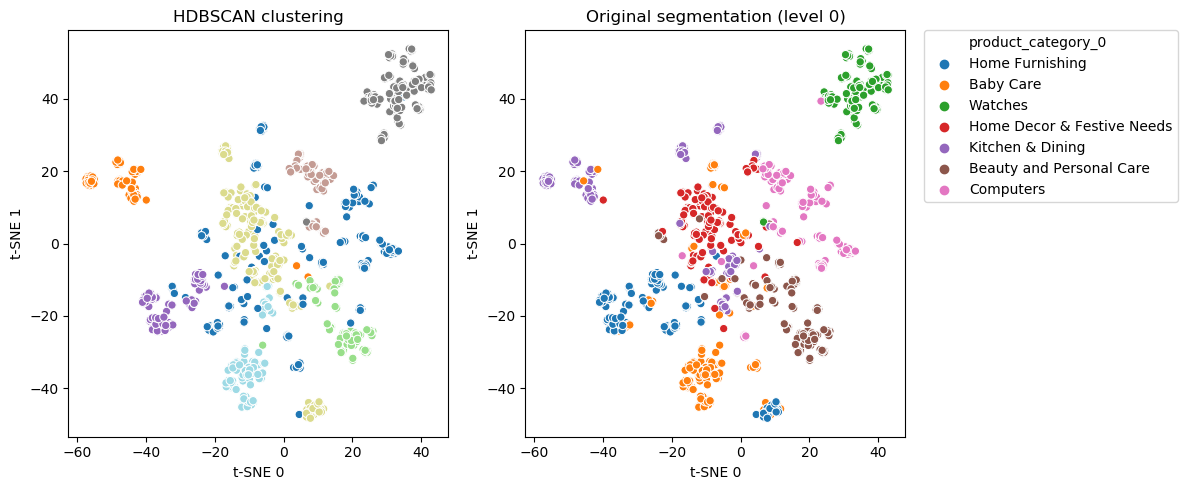

In [815]:
X_tsne = tsne.embedding_

# Visualisation
visualize_tsne(df, X_tsne, "hdbs_label", title="HDBSCAN clustering")

**Réassignation des points étiquetés "bruit" à la catégorie la plus proche**

In [821]:
labels_wo_noise = np.arange(0, 7)
centroids = []

# centroïdes des catégories non étiquetées 'bruit'
for l in labels_wo_noise:
    cluster_indices = np.where(df.hdbs_label==l)
    centroids.append(X_tsne[cluster_indices].sum(axis=0) / len(cluster_indices[0]))

# bruit
noise_samples_ind = np.where(df.hdbs_label==-1)
noise_samples = X_tsne[noise_samples_ind]

# distance des points au cluster le plus proche
dist_to_centroids = []
for ns in noise_samples:
    dist_to_centroids.append(np.square(ns - centroids).sum(axis=1))

cat_assign = np.asarray(dist_to_centroids).argmin(axis=1)

# assignation des points au cluster le plus proche
cat_assign = pd.Series(data=cat_assign, index=df[df.hdbs_label==-1].index)
cond = df.hdbs_label==-1

df['hdbs_label'] = df['hdbs_label'].mask(cond).fillna(cat_assign, downcast='infer')

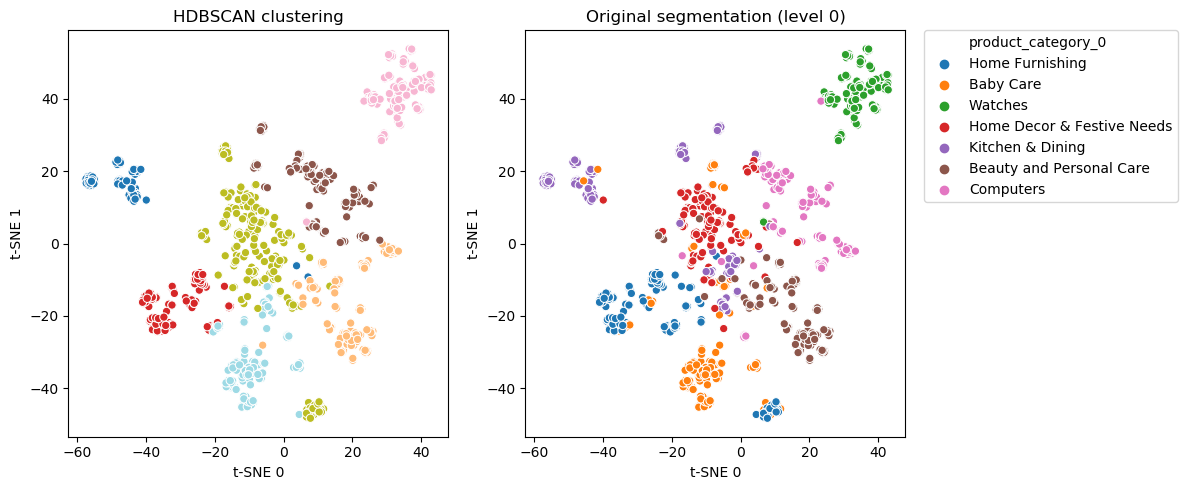

In [823]:
# Visualisation
visualize_tsne(df, X_tsne, "hdbs_label", title="HDBSCAN clustering")

**3. Evaluation de la segmentation** 

In [824]:
# Evaluation
eval_clustering(df.label_0, df.hdbs_label)

ARI entre les étiquettes obtenues par LDA et les vraies étiquettes: 0.51


**4. Inspection de la matrice de confusion**

La matrice de confusion est réorganisée comme ci-dessus.

Correspondance des clusters :  [5 1 4 2 6 3 0]


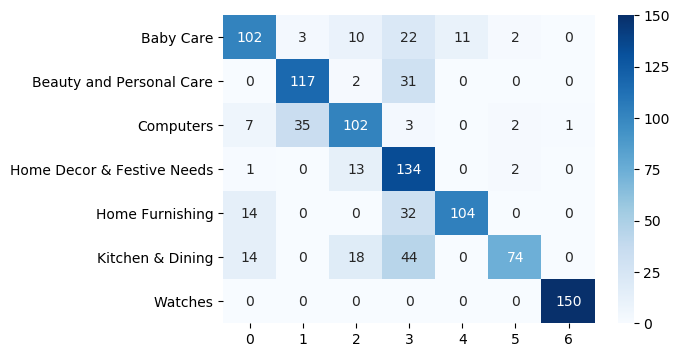

In [826]:
label_classes = np.unique(le.inverse_transform(labels_0))
labels_transform = conf_mat_transform(labels_0, df.hdbs_label.values)
conf_mat = metrics.confusion_matrix(labels_0, labels_transform)
df_cm = pd.DataFrame(conf_mat, index = [label for label in np.unique(label_classes)],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.0f')
plt.show()

In [827]:
print(metrics.classification_report(labels_0, labels_transform))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71       150
           1       0.75      0.78      0.77       150
           2       0.70      0.68      0.69       150
           3       0.50      0.89      0.64       150
           4       0.90      0.69      0.78       150
           5       0.93      0.49      0.64       150
           6       0.99      1.00      1.00       150

   micro avg       0.75      0.75      0.75      1050
   macro avg       0.79      0.75      0.75      1050
weighted avg       0.79      0.75      0.75      1050



100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


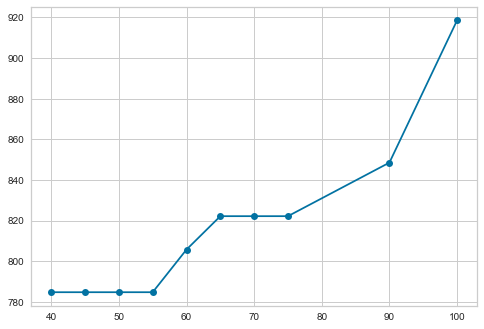

In [875]:
distorsions = []
minclustersize = [40, 45, 50, 55, 60, 65, 70, 75, 90, 100]

for mcs in tqdm(minclustersize):
    # Créer le modèle LDA
    hdbs = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=mcs)
    
    # Fitter sur les données - on utilise la matrice "bag-of-words"
    hdbs.fit(X_lsa)
    
    # Assignation des catégories à chaque produit: la catégorie retenue est celle pour laquelle la proba est maximale
    
    #X_topics = lda.transform(docterm)
    #topics = np.argmax(X_topics, axis=1)
    
    topics = hdbs.labels_
    
    # score de distorsion
    distorsions.append(compute_distorsion(X_lsa, topics))
    

plt.plot(minclustersize, distorsions, 'o-')

In [1032]:
# Créer le modèle LDA
hdbs = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=75)
    
# Fitter sur les données - on utilise la matrice "bag-of-words"
hdbs.fit(X_lsa)
    
# Assignation des catégories à chaque produit: la catégorie retenue est celle pour laquelle la proba est maximale

#X_topics = lda.transform(docterm)
#topics = np.argmax(X_topics, axis=1)
print("Nombre de clusters trouvés (le bruit compte pour un cluster): {}"
          .format(len(np.unique(hdbs.labels_))))
print("silhouette score pour les clusters: {:.2f}".format(metrics.silhouette_score(X_tsne, hdbs.labels_)))

Nombre de clusters trouvés (le bruit compte pour un cluster): 7
silhouette score pour les clusters: 0.16


In [1033]:
print("silhouette score pour les catégories originales: {:.2f}".format(metrics.silhouette_score(X_tsne, data.label_0)))

silhouette score pour les catégories originales: 0.30
